# Running Analysis on One Grid
<br>

[Skeleton Functions](#Skeleton-Functions)

[Slice Analysis Functions](#Slice-Analysis-Functions)

[Color Map Functions](#Color-Map-Functions)

[Animation Function](#Animation-Function)

[Gaussian Function](#Gaussian-Function)

[Table Function](#Create-Table)

[User Section](#User-Section)
<br><br>
How to use : Make sure you have installed all the necessary packages into a conda environment (see Installation-Instructions). Make sure the simulation or observation .fits files are in same folder as code. Run all the cells until you reach the User Section. 

In [1]:
################################################
# 
# Imports
#
################################################

from skimage.morphology import flood    
import skimage.morphology as mo
from sklearn.neighbors import NearestNeighbors

from astropy.io import fits
from astropy.table import QTable
from astropy.io import ascii
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.table import Table, hstack

# See Installation-Instructions for fil finder installation instructions
from fil_finder import FilFinderPPP

import math

import numpy as np

import scipy
from scipy import interpolate
from scipy.interpolate import splprep, splev
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial import distance

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import PillowWriter
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolor
from matplotlib.colors import BoundaryNorm

import pyvista as pv

import glob

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Skeleton Functions

In [2]:
################################################
# 
# Skeleton Functions
#
################################################

################################################
## Sorting Functiuon
################################################

# The skeleton (fil finder) returns an array that is ordered by z. This sorts by order
# INPUTS  : Skeleton coordinates (from skeletonize functon)
# OUTPUTS : Ordered skeleton and total distance (in pc) of skeleton

def sort_skeleton(skeleton_coords):
    
    z = skeleton_coords[0]
    y = skeleton_coords[1]
    x = skeleton_coords[2]
    
    # make the point list (N x 3)
    pts=np.vstack((z,y,x)).T

    # initiate the NN2 and the network graph
    try:
        clf = NearestNeighbors(2).fit(pts)
    except:
        clf = NearestNeighbors(n_neighbors = 2).fit(pts)    
    G = clf.kneighbors_graph()
    T = nx.from_scipy_sparse_matrix(G)

    # candidate paths based on the network graph
    paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(pts))]
    ## find the path with the lowest cost (distance) among the candidates
    minidx = np.argmin([np.sum(np.diagonal(distance.cdist(pts[path], pts[path]), offset = 1)) for path in paths])
    opt_order = paths[minidx]
    ## permute the head and the tail to find the correct order
    ### permutation
    opt_order_swaphead = list(opt_order)
    opt_order_swaphead[0], opt_order_swaphead[1] = opt_order_swaphead[1], opt_order_swaphead[0]
    opt_order_swaptail = list(opt_order)
    opt_order_swaptail[-1], opt_order_swaptail[-2] = opt_order_swaptail[-2], opt_order_swaptail[-1]
    ### find the correct order among the original and the two permuted
    paths_opt = [opt_order, opt_order_swaphead, opt_order_swaptail]
    minidx_opt = np.argmin([np.sum(np.diagonal(distance.cdist(pts[path], pts[path]), offset = 1)) for path in paths_opt])
    opt_order_final = paths_opt[minidx_opt]

    # return the ordered coordinates
    zz = z[opt_order_final]
    yy = y[opt_order_final]
    xx = x[opt_order_final]
    
    # Array to be returned in (z_array,y_array,x_array) format
    sorted_skeleton = [zz,yy,xx]
     
    # Returns array in (z,y,x) list format
    sorted_skeleton_coord = np.transpose(sorted_skeleton)
    
    # Calculate distance
    distances = []
    for m in range(len(sorted_skeleton_coord)-1): 
        distances.append(math.dist(sorted_skeleton_coord[m],sorted_skeleton_coord[m+1]))
    
    
    return sorted_skeleton, np.sum(distances)

################################################
# Skeletonize Function 
################################################

# INPUTS  :  file_name (string), threshold_level (int), ball size of mo.ball
# OUTPUTS :  Saves fits file with every skeleton in it, as well as other fits files and masses
#            Returns and saves skeletons array for splines and splices (next step)
def skeletonize(file_name,threshold_level,ball_size):
    
    # Constant to return how many skeletons were made, and their lengths and masses
    num_skeletons = 0
    length_of_skeletons = []
    mass_of_skeletons = []
    
    # Number of errors 
    error_num = 0
    
    # Load in data 
    data,header = fits.getdata(file_name,header=True)
    
    # Create interpolated nhtot for future masses
    z = np.linspace(0,data.shape[0]-1,data.shape[0])+0.5
    y = np.linspace(0,data.shape[1]-1,data.shape[1])+0.5
    x = np.linspace(0,data.shape[2]-1,data.shape[2])+0.5
    interpolate_data = RegularGridInterpolator((z,y,x), data, method = 'nearest',bounds_error=False, fill_value = 0)
    
    # Create empty array to hold the skeletons 
    skeleton_array = np.zeros(data.shape)
    
    # Create array just to hold each skeleton seperately 
    skeletons_for_splines = []
    
    # Create the masked data 
    thresholded_data = (data > threshold_level).astype(int)
    
    # Create list of 3d coordinates (i.e. converts three arrays to list of (x,y,z)'s)
    thresholded_data_coord = np.where(thresholded_data == 1)
    thresholded_data_coord_ordered = []
    
    for n in range(len(thresholded_data_coord[0])): 
        
        x = thresholded_data_coord[0][n]
        y = thresholded_data_coord[1][n]
        z = thresholded_data_coord[2][n]
        thresholded_data_coord_ordered.append([x,y,z])
        
    # Loop through each index of thresholded data coordinates 
    for n in range(len(thresholded_data_coord_ordered)):
        
        # Defines the (x,y,z)
        in_mask_point = (thresholded_data_coord_ordered[n][0], thresholded_data_coord_ordered[n][1], thresholded_data_coord_ordered[n][2])
        
        # Skip iteration if point is only 0s
        if(thresholded_data_coord_ordered[n][0] == 0 and 
          thresholded_data_coord_ordered[n][1] == 0 and
          thresholded_data_coord_ordered[n][2] == 0):
            continue 
        
        # Else, keep going 
        
        # Extract features around this point using flood 
        mask_interim = flood(thresholded_data,in_mask_point,tolerance=0).astype(int)
        
        # Remove masked points from thresholded_data_coord
        mask_interim_coord = np.where(mask_interim == 1) # Loads only points with values 
        mask_interim_coord_ordered = []
        
        # Same process as for thresholded data, converts 3 arrays to (x,y,z)'s
        for m in range(len(mask_interim_coord[0])): 
            x = mask_interim_coord[0][m]
            y = mask_interim_coord[1][m]
            z = mask_interim_coord[2][m]
            mask_interim_coord_ordered.append([x,y,z])
        
        # Gets a list of indices in threshold where they are equal 
        index_where_equal = []
        
        # Loops through each point and checks to see if there are any exact matches 
        # If there is, it records the index in thresholded data 
        for m in range(len(thresholded_data_coord_ordered)):
            for b in mask_interim_coord_ordered:
                if thresholded_data_coord_ordered[m] == b : 
                    index_where_equal.append(m)
       
        # Set all the points to 0 that match exactly with mask_interim
        for m in index_where_equal:
            thresholded_data_coord_ordered[m][0] = 0
            thresholded_data_coord_ordered[m][1] = 0
            thresholded_data_coord_ordered[m][2] = 0
        
        # Stop loop if there aren't enough points 
        if(len(mask_interim_coord[0])<100):
            continue
        
        # Continue with normal code 
        
        # Fill in small holes useing dilation and closing 
        selem = mo.ball(ball_size)
        mask_final = mo.dilation(mask_interim, selem)
        mask_final = mo.closing(mask_final)
        
        # Add a pad of 0s around the data array to avoid edge errors
        mask_final = np.pad(mask_final, ((1,1),(1,1),(1,1)), 'constant')
        
        # Skeletize a mask using filfinder
        data = mask_final
        
        fil = FilFinderPPP(data, mask=mask_final)
        fil.preprocess_image(skip_flatten=True)
        fil.create_skeleton(min_pixel=0)
        
        # Check for errors 
        try:
            fil.analyze_skeletons(test_print=0, branch_thresh=0 * u.pix, do_prune=True)
        except:
            error_num += 1
            continue
        
        # If no error, keep going
        fil.analyze_skeletons(test_print=0, branch_thresh=0 * u.pix, do_prune=True)
        skeleton  = fil.skeleton_longpath 
        
        # Sort Skeleton for distance function (only keep skeletons > 20 parsecs)
        skeleton_sorted = skeleton[1:-1,1:-1,1:-1]
        skeleton_sorted = np.where(skeleton_sorted==1)
        try :
            skeleton_sorted, distance = sort_skeleton(skeleton_sorted)
        except:
            distance = 0
        
        # Only saves if a skeleton is above or equal to 20 pc 
        if distance >= 20: 
            
            # To print at the end
            num_skeletons += 1
            length_of_skeletons.append(distance)
            
            # Remove the pad 
            skeleton = skeleton[1:-1,1:-1,1:-1]
            
            # Where the skeleton exists
            x_pix, y_pix, z_pix = np.where(skeleton==1)
            
            # Setting those same values in the skeleton array
            skeleton_array[x_pix,y_pix,z_pix] = 1
            
            # Create the sorted skeleton
            skeleton_sorted = skeleton[1:-1,1:-1,1:-1]
            skeleton_sorted = np.where(skeleton_sorted==1)
            skeleton_sorted, distance = sort_skeleton(skeleton_sorted)
            
            # For splines and splice, each skeleton is saved in a new array 
            skeletons_for_splines.append((skeleton_sorted[0],skeleton_sorted[1],
                                          skeleton_sorted[2]))
            
            # Save each mass (uses thresholded masked data)
            # dM = m (g) * nhtot (cm^-3) * dV (pc^3=>cm^3) = g
            points = np.where(data==1)
            z = points[0]
            y = points[1]
            x = points[2]
    
            points = (z,y,x)
            points = np.transpose(points)
            
            pc_cubed = 2.93799895e55         #cm^3
            m = 2.34e-24                     #grams
            nhtot = interpolate_data(points) #cm^-3
            m_sun = 1.9891e33
            
            mass = np.sum(nhtot*m*pc_cubed/m_sun) # solar masses
            
            mass_of_skeletons.append(mass)
            
    # Output for user
    print()
    print("Number of skeletons :", num_skeletons)
    print("Their lengths are :", length_of_skeletons)
    print("Their masses are :", mass_of_skeletons)
    print("Number of errors :", error_num)
    
    # Saving 
    file_name_to_save = file_name.removesuffix(".fits")
    file_name_to_save = file_name_to_save + "_" + str(threshold_level) + "_"
            
    # Note : If you want mask_interim and mask_final just comment out the below 
    fits.writeto(file_name_to_save + "thresholded_data.fits",thresholded_data,header,overwrite=True)
    #fits.writeto(file_name + "mask_interim.fits",mask_interim,header,overwrite=True)
    #fits.writeto(file_name + "mask_final.fits",mask_final,header,overwrite=True)
    fits.writeto(file_name_to_save + "skeleton.fits",skeleton_array,header,overwrite=True)
    
    # Save the seperate skeleton arrays and mass array 
    np.save(file_name_to_save + 'masses.npy', mass_of_skeletons)
    np.save(file_name_to_save + 'skeleton_array.npy', skeletons_for_splines)
    
    return skeletons_for_splines

# Slice Analysis Functions

In [3]:
################################################
## Slice Analysis Functions
################################################

################################################
# Interpolation 
################################################
# INPUTS  : data, index, designation 
# OUTPUTS : all interpolation functions
def interpolating_functions(data, designation):
    
    # Make the pixel grid 
    z = np.linspace(0,data.shape[0]-1,data.shape[0])+0.5
    y = np.linspace(0,data.shape[1]-1,data.shape[1])+0.5
    x = np.linspace(0,data.shape[2]-1,data.shape[2])+0.5
    
    
    # Interpolate 
    # Try with method = nearest, fill_value = 0
    interpolate_data = RegularGridInterpolator((z,y,x), data, method = 'nearest',bounds_error=False, fill_value = 0)

    interpolate_array = [interpolate_data]
    
    return interpolate_array

################################################
# Radial density function
################################################
# INPUTS  : extract_z, extract_y, extract_x, data, new_points, index, designation, interpolate array 
# OUTPUTS : plots radial density vs density, returns medians to put into array of medians
#.          also outputs edges
def radial_density(extract_z, extract_y, extract_x, data, new_points, index, 
                   designation, interpolate_array, shift):
    
    # Grab the interpolating functions
    interpolate_data = interpolate_array[0]
    
    # Convert z,y,x to an array that interpolate can actually use 
    points_array = np.array([extract_z,extract_y,extract_x])
    points_array = np.transpose(points_array)
    
    # Make radial density and density arrays 
    
    densities = interpolate_data(points_array)
    radial_distance_array = []

    point_on_spline = (new_points[0][index],new_points[1][index],new_points[2][index])
    
    
    # Shifting 
    # Ok after this point you have the point on the spline. We need to check to 
    # see if its the peak density is closer 
    # This function does one point on the spline at a time, so no need to loop over every point
    
    if shift == True:
        densities_in_5_pc_neighborhood = []
        # Find all the peak densities in the area of the spline.
        # Extract z,y,x are the coordinates of the 'slice'
        for n in range(len(extract_z)):
            radial_distance = math.dist(point_on_spline,(extract_z[n],extract_y[n],extract_x[n]))
            
            if radial_distance <= 5:
                densities_in_5_pc_neighborhood.append([radial_distance,
                                                      extract_z[n],extract_y[n],extract_x[n],
                                                        densities[n]])
        # Now find the max in that array 
        densities_in_5_pc_neighborhood = np.array(densities_in_5_pc_neighborhood)
        radial_distance_only = densities_in_5_pc_neighborhood.T[0]
        z_only = densities_in_5_pc_neighborhood.T[1]
        y_only = densities_in_5_pc_neighborhood.T[2]
        x_only = densities_in_5_pc_neighborhood.T[3]
        densities_only = densities_in_5_pc_neighborhood.T[4]
        
        max_density_index = np.argmax(densities_only)
        new_spline_point = (z_only[max_density_index],y_only[max_density_index],x_only[max_density_index])
        print('New Spline Point =', new_spline_point )
        print('Max density in 5 pc =', densities_only[max_density_index])
        print()
        
        # Print old density 
        spline_point_index = np.argmin(radial_distance_only)
        print('Old Spline Point =', point_on_spline)
        print('Density = ', densities_only[spline_point_index])
        print()
        
        # Redefine point on spine 
        point_on_spline = new_spline_point
    
    # Now we make slices
    for n in range(len(extract_z)):
        radial_distance = math.dist(point_on_spline,(extract_z[n],extract_y[n],extract_x[n]))
        if radial_distance <= 20:
            radial_distance_array.append([radial_distance,
                                          extract_z[n],extract_y[n],extract_x[n],
                                          densities[n],])
    # Plot 
    
    # Add the origin point (i.e. the point on spline) manually 
    radial_distance_array.append([0,point_on_spline[0],point_on_spline[1],point_on_spline[2],
                                 interpolate_data(point_on_spline)])
    
    # Check for errors
    if radial_distance_array == []:
        print('Radial array is empty')
        return
       
    
    # If none, continue
    radial_distance_array_T = np.transpose(radial_distance_array)
    x = radial_distance_array_T[0]
    y_nhtot = radial_distance_array_T[4]
    
    
    # Bin Stuff 
    bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,
           10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,
           18.5,19,19.5,20]

    s_nhtot, edges, _ = binned_statistic(x,y_nhtot, statistic='median', bins = bins)
    
    return s_nhtot,edges

################################################
# Create Spline Function
################################################
# INPUTS  : skeleton data, k order for spline
# OUTPUTS : Returns new_points (3 column array)
#.          Also returns derivative. Spline saved in next step
def create_spline(skeleton,k_num):

    # In this version of the code, np.where(skeleton == 1) done already so 
    skeleton_coordinates = skeleton
    z_pix = skeleton_coordinates[0]
    y_pix = skeleton_coordinates[1]
    x_pix = skeleton_coordinates[2]

    tck, u = interpolate.splprep([z_pix,y_pix,x_pix], k=k_num, nest=-1)
    new_points = splev(u, tck)
    derivatives = splev(u, tck, der=1)
    
    return new_points, derivatives
    
    
################################################
# Create Plane Function
################################################
# INPUTS  : skeleton data, order number, 
#          shape of data, data (nhtot)
#          designation = x1465y1390z1395
#.         skeleton index number for file writing
# OUTPUTS : Radial Distance vs Everything Graphs 
def create_plane(skeleton,k_num,data_shape,data,designation,skeleton_index,
                 sort_plus_threshold_name, shift):
    
    # Creating list of radial densities to make a final plot 
    radial_nhtot_medians = []
    radial_nhtot_std = []
    
    # Save spline points for length 
    SPLINE_POINTS = []
    
    #Create interpolation functions 
    interpolate_array = interpolating_functions(data, designation)
    
    new_points,derivatives = create_spline(skeleton,k_num)
    
    print('Number of points in spline :',len(new_points[0]))
    print()
    
    # Making list of points for saving and looping 
    splice_points = [new_points[0], new_points[1], new_points[2]]
    
    point = []

    for n in range(len(splice_points[0])):
        point.append([splice_points[0][n],splice_points[1][n],splice_points[2][n]])
    
    # Making the normals for each point
    normal = []  
    
    # Dr. Zucker's code (-1, -dy/dx, -dz/dx)
    for n in range (len(derivatives[0])):
        slope_x = -1./(derivatives[0][n]/derivatives[2][n])
        slope_y = -1./(derivatives[0][n]/derivatives[1][n])
        normal.append([-1,slope_y,slope_x])
    
    # For saving the normals 
    x_normal = []
    y_normal = []
    z_normal = []

    for n in range(len(normal)):
        
        norm = np.sqrt(normal[n][0]**2 + normal[n][1]**2 + normal[n][2]**2) # normalized
        norm = 1
        z_normal.append(normal[n][0]/norm)
        y_normal.append(normal[n][1]/norm)
        x_normal.append(normal[n][2]/norm)

    normal_vectors = [z_normal, y_normal, x_normal]
    
    # Making the splice
    grid = pv.UniformGrid()
    grid.dimensions = data_shape
    grid.origin = (0, 0, 0)  
    grid.spacing = (1, 1, 1)
    
    for n in range(len(point)):
        
        print(n)
        single_slice = grid.slice(origin=point[n], normal=normal[n])

        extract_z = single_slice.points[:,0]
        extract_y = single_slice.points[:,1]
        extract_x = single_slice.points[:,2]
             
        # Radial density graph 
        s_nhtot,edges = radial_density(extract_z, extract_y, 
                                    extract_x, data, new_points, 
                                    n, designation,interpolate_array,shift)
        radial_nhtot_medians.append(s_nhtot)
    
    # Printing out medians of all radial graphs 
    radial_nhtot_medians_stack = np.transpose(radial_nhtot_medians)
    
    # Just to loop through
    medians_stack = [radial_nhtot_medians_stack]
    
    plot_names = ['nhtot']
    plot_units = [' (cm^-3)']
    name_counter = 0
    
    diff = np.diff(edges)[0]
    
    for radial_density_medians_stack in medians_stack:
        
        fig, ax = plt.subplots()
    
        for n in range(len(radial_density_medians_stack)):
            x = []
            for m in range(len(radial_density_medians_stack[n])):
                x.append(edges[n]+diff/2)
            ax.scatter(x, radial_density_medians_stack[n], c="limegreen", zorder=3)
    
        medians_of_medians = np.nanmedian(radial_density_medians_stack,axis=1)
        ax.scatter(edges[:-1]+np.diff(edges)/2, medians_of_medians, c="blue", zorder=3)
    
        fig.set_size_inches(18.5, 10.5)
        plt.title("Median " + plot_names[name_counter] + plot_units[name_counter] + 
                  " vs. Radial Distance (pc)")
        plt.xlabel("Radial Distance (pc)")
        plt.ylabel(plot_names[name_counter] + plot_units[name_counter])
        plt.show()
        
        name_counter +=1
        
    # Plotting all the medians on one graph at the end 
    medians_nhtot = np.nanmedian(radial_nhtot_medians_stack,axis=1)
    
    # Save scatter plots
    medians_stack = [radial_nhtot_medians_stack]
    
    # Switch nh2 and nh1 
    file_name_to_save = sort_plus_threshold_name + designation + '_skeleton_' + str(skeleton_index) + '_scatters.npy'
    np.save(file_name_to_save, medians_stack)
    
    # Save medians of medians
    medians = [edges,medians_nhtot]
    file_name_to_save = sort_plus_threshold_name + designation + '_skeleton_' + str(skeleton_index) + '_medians.npy'
    
    np.save(file_name_to_save, medians)
    
    # Save spline points for length 
    save_string = sort_plus_threshold_name + designation + "_" + str(skeleton_index) + "_SPLINE_POINTS.npy"
    np.save(save_string,new_points)

In [4]:
################################################
## Splice Analysis (for color map)
################################################

# The only difference is that these only do one plane and spline, instead of them all

# Creates the spline from skeleton data 
# INPUTS  : skeleton data, k order for spline
# OUTPUTS : Returns new_points (3 column array)
#.          Also returns derivative. Spline saved in next step
def create_spline_color(skeleton,k_num):

    #skeleton_coordinates = np.where(skeleton == 1)
    skeleton_coordinates = skeleton
    z_pix = skeleton_coordinates[0]
    y_pix = skeleton_coordinates[1]
    x_pix = skeleton_coordinates[2]

    tck, u = interpolate.splprep([z_pix,y_pix,x_pix], k=k_num, nest=-1)
    new_points = splev(u, tck)
    derivatives = splev(u, tck, der=1)
    
    return new_points, derivatives
        
# Does the above but takes in the point number
# INPUTS  : skeleton data, order number, 
#          shape of data, point for analaysis, new_points, and derivatives
# OUTPUTS : Saves spline with vectors and plane
#.          returns spline and slice to figure out radial distance
def create_plane_color(skeleton,k_num,data_shape,point_number,new_points,derivatives):
    
    splice_points = [new_points[0], new_points[1], new_points[2]]
    
    point = []

    for n in range(len(splice_points[0])):
        point.append([splice_points[0][n],splice_points[1][n],splice_points[2][n]])
    
    normal = []  
    
    # Dr. Zucker's code (-1, -dy/dx, -dz/dx)
    for n in range (len(derivatives[0])):
        slope_x = -1./(derivatives[0][n]/derivatives[2][n])
        slope_y = -1./(derivatives[0][n]/derivatives[1][n])
        normal.append([-1,slope_y,slope_x])
    
    # For saving only 
    x_normal = []
    y_normal = []
    z_normal = []

    for n in range(len(normal)):
        
        norm = np.sqrt(normal[n][0]**2 + normal[n][1]**2 + normal[n][2]**2) # normalized
        norm = 1
        z_normal.append(normal[n][0]/norm)
        y_normal.append(normal[n][1]/norm)
        x_normal.append(normal[n][2]/norm)

    normal_vectors = [z_normal, y_normal, x_normal]
    
    # This part in reality should be a seperate funtion since whole line is calculated
    grid = pv.UniformGrid()
    grid.dimensions = data_shape
    grid.origin = (0, 0, 0)  
    grid.spacing = (1, 1, 1)  

    single_slice = grid.slice(origin=point[point_number], normal=normal[point_number])
    
    return new_points,single_slice,normal[point_number]
    

# Color Map Functions

In [5]:
################################################
## Splice Analysis (for color map)
################################################

# The only difference is that these only do one plane and spline, instead of them all

# Creates the spline from skeleton data 
# INPUTS  : skeleton data, k order for spline
# OUTPUTS : Returns new_points (3 column array)
#.          Also returns derivative. Spline saved in next step
def create_spline_color(skeleton,k_num):

    #skeleton_coordinates = np.where(skeleton == 1)
    skeleton_coordinates = skeleton
    z_pix = skeleton_coordinates[0]
    y_pix = skeleton_coordinates[1]
    x_pix = skeleton_coordinates[2]

    tck, u = interpolate.splprep([z_pix,y_pix,x_pix], k=k_num, nest=-1)
    new_points = splev(u, tck)
    derivatives = splev(u, tck, der=1)
    
    return new_points, derivatives
        
# Does the above but takes in the point number
# INPUTS  : skeleton data, order number, 
#          shape of data, point for analaysis, new_points, and derivatives
# OUTPUTS : Saves spline with vectors and plane
#.          returns spline and slice to figure out radial distance
def create_plane_color(skeleton,k_num,data_shape,point_number,new_points,derivatives):

    #new_points,derivatives = create_spline(skeleton,k_num)
    
    #print('Number of points in spline :',len(new_points[0]))
    
    splice_points = [new_points[0], new_points[1], new_points[2]]
    
    point = []

    for n in range(len(splice_points[0])):
        point.append([splice_points[0][n],splice_points[1][n],splice_points[2][n]])
    
    normal = []  
    
    # Dr. Zucker's code (-1, -dy/dx, -dz/dx)
    for n in range (len(derivatives[0])):
        slope_x = -1./(derivatives[0][n]/derivatives[2][n])
        slope_y = -1./(derivatives[0][n]/derivatives[1][n])
        normal.append([-1,slope_y,slope_x])
    
    # For saving only 
    x_normal = []
    y_normal = []
    z_normal = []

    for n in range(len(normal)):
        
        norm = np.sqrt(normal[n][0]**2 + normal[n][1]**2 + normal[n][2]**2) # normalized
        norm = 1
        z_normal.append(normal[n][0]/norm)
        y_normal.append(normal[n][1]/norm)
        x_normal.append(normal[n][2]/norm)

    normal_vectors = [z_normal, y_normal, x_normal]
    
    # This part in reality should be a seperate funtion since whole line is calculated
    grid = pv.UniformGrid()
    grid.dimensions = data_shape
    grid.origin = (0, 0, 0)  
    grid.spacing = (1, 1, 1)  

    single_slice = grid.slice(origin=point[point_number], normal=normal[point_number])
    
    
    return new_points,single_slice,normal[point_number]
    

In [6]:
################################################
## Color Map Slice Function
################################################

# Creates the color maps for everyy point in a spline 
# INPUTS  : file name (str), sim_skeletons (arr of skeletons), skeleton index (int)
#.          designation (ex 'x1465y1390z1395')
# OUTPUTS : Color Maps for every point, saves for animation 

def color_maps(file_name,sim_skeletons,skeleton_index,designation,sort_plus_threshold_name, shift):

    COLORMAPS_ARRAY = []
    SPLINE_POINTS = []
    
    data,header = fits.getdata(file_name,header=True)
    data_shape = data.shape

    k_num = 1

    skeleton = sim_skeletons[skeleton_index]

    new_points,derivatives = create_spline_color(skeleton,k_num)
    
    interpolate_array = interpolating_functions(data, designation)
    
    print('Number of points in spline :',len(new_points[0]))

    for n in range(len(new_points[0])):
    
        print(n)
        point_number = n

        # New points = spline 
        # slice = plane 
        new_points,single_slice,normal = create_plane_color(skeleton,k_num,data_shape,point_number,new_points,derivatives)
    
        # Getting radial density array 

        extract_z = single_slice.points[:,0]
        extract_y = single_slice.points[:,1]
        extract_x = single_slice.points[:,2]
        
        # Interpolation 
        # Grab the interpolating functions
        interpolate_data = interpolate_array[0]
    
        # Convert z,y,x to an array that interpolate can actually use 
        points_array = np.array([extract_z,extract_y,extract_x])
        points_array = np.transpose(points_array)
    
        # Make radial density and density arrays 
    
        densities = interpolate_data(points_array)
        radial_distance_array = []

        # Each element is a tuple (distance (pixels), z, y, x)
        radial_distance_array = []
        extract_z_array = [] # So that you can graph using non int numbers 
        extract_y_array = []
        extract_x_array = []

        point_on_spline = (new_points[0][point_number],new_points[1][point_number],new_points[2][point_number])

        # Shifting 
        # Ok after this point you have the point on the spline. We need to check to 
        # see if its the peak density is closer 
        # This function does one point on the spline at a time, so no need to loop over every point

        if shift == True:
            densities_in_5_pc_neighborhood = []
            # Find all the peak densities in the area of the spline.
            # Extract z,y,x are the coordinates of the 'slice'
            for n in range(len(extract_z)):
                radial_distance = math.dist(point_on_spline,(extract_z[n],extract_y[n],extract_x[n]))

                if radial_distance <= 5:
                    densities_in_5_pc_neighborhood.append([radial_distance,
                                                          extract_z[n],extract_y[n],extract_x[n],
                                                            densities[n]])
            # Now find the max in that array 
            densities_in_5_pc_neighborhood = np.array(densities_in_5_pc_neighborhood)
            radial_distance_only = densities_in_5_pc_neighborhood.T[0]
            z_only = densities_in_5_pc_neighborhood.T[1]
            y_only = densities_in_5_pc_neighborhood.T[2]
            x_only = densities_in_5_pc_neighborhood.T[3]
            densities_only = densities_in_5_pc_neighborhood.T[4]

            max_density_index = np.argmax(densities_only)
            new_spline_point = (z_only[max_density_index],y_only[max_density_index],x_only[max_density_index])
            print('New Spline Point =', new_spline_point )
            print('Max density in 5 pc =', densities_only[max_density_index])
            print()

            # Print old density 
            spline_point_index = np.argmin(radial_distance_only)
            print('Old Spline Point =', point_on_spline)
            print('Density = ', densities_only[spline_point_index])
            print()
        
            # Redefine point on spine 
            point_on_spline = new_spline_point
        
        for n in range(len(extract_z)):
    
            radial_distance = math.dist(point_on_spline,(extract_z[n],extract_y[n],extract_x[n]))
    
            if radial_distance <= 20:
                radial_distance_array.append([radial_distance,
                                              extract_z[n],extract_y[n],extract_x[n],
                                              densities[n]])
            
                extract_z_array.append(extract_z[n])
                extract_y_array.append(extract_y[n])
                extract_x_array.append(extract_x[n])
        
        radial_distance_array_T = np.transpose(radial_distance_array)

        rad_distance = radial_distance_array_T[0]
        y_nhtot = radial_distance_array_T[4]
    
        ##############################
        # U, V plots 
        ##############################
        p1 = point_on_spline # origin
        A, B, C = W = normal # normal vector

        D = -1 * np.dot(W, p1)

        magnitude = np.linalg.norm(W)
        normal = W / magnitude

        if A != 0:
            u_not_normalized = np.array([B, -A, 0])
        else:
            u_not_normalized = np.array([0, B, -C])
        u_magnitude = np.linalg.norm(u_not_normalized)

        U = u_not_normalized / u_magnitude
        V = np.cross(normal, U)

        u_array = []
        v_array = []

        for n in range(len(extract_z_array)):
            z = extract_z_array[n]
            y = extract_y_array[n]
            x = extract_x_array[n]
            p3 = (z,y,x)
    
            u_new = np.dot(U,np.subtract(p3,p1))
            v_new = np.dot(V,np.subtract(p3,p1))

            u_array.append(u_new)
            v_array.append(v_new)
        
        u_array = np.array(u_array)
        v_array = np.array(v_array)
            
        # Mark the point cloest to 0 first 
        distances_to_origin = []
        for m in range(len(extract_z_array)): 
            point = (extract_z_array[m],extract_y_array[m],extract_z_array[m])
            distances_to_origin.append(math.dist((point),(0,0,0)))
    
        index = np.where(distances_to_origin == np.amin(distances_to_origin))[0][0]
        p3 = (extract_z_array[index],extract_y_array[index],extract_x_array[index])
        u_closest_to_origin = np.dot(U,np.subtract(p3,p1))
        v_closest_to_origin = v_new = np.dot(V,np.subtract(p3,p1))
        
        # Find the angle of this point from x axis 
        # math.atan2(y,x) and returns a radian between pi and -pi 
        # Positive pi = y>0
        angle_radians = math.atan2(v_closest_to_origin,u_closest_to_origin)
        
        if angle_radians < 0:
            angle_radians = (2*np.pi) + angle_radians
        
        # Try to rotate to x>0, y=0 axis 
        if angle_radians != 0:
            u_closest_to_origin_new = (u_closest_to_origin * math.cos(angle_radians) 
                                   + v_closest_to_origin * math.sin(angle_radians))
            v_closest_to_origin_new = (-u_closest_to_origin * math.sin(angle_radians) 
                                   + v_closest_to_origin * math.cos(angle_radians))
            u_closest_to_origin_rotated,v_closest_to_origin_rotated = u_closest_to_origin_new,v_closest_to_origin_new
        
        
        # Rotated Plot circles 
        
        #print("Rotated :",angle_radians*(180/np.pi),"Degrees CW")
        degrees = angle_radians*(180/np.pi)
        
        if angle_radians != 0:
            u_rotated = (u_array * math.cos(angle_radians) 
                         + v_array * math.sin(angle_radians))
            v_rotated= (-u_array* math.sin(angle_radians) 
                         + v_array * math.cos(angle_radians))
            
        COLORMAPS_ARRAY.append([u_rotated,v_rotated,y_nhtot,np.log10(y_nhtot)])
    
        
       
    save_string = sort_plus_threshold_name + "_" + str(skeleton_index) + "_COLORMAPS_ARRAY"
    np.save(save_string,COLORMAPS_ARRAY)
    save_string = sort_plus_threshold_name + "_" + str(skeleton_index) + "_COLOR_SPLINE_POINTS"
    np.save(save_string,new_points)

# Animation Function


In [7]:
################################################
## Animation Functions 
################################################

import matplotlib.colors as mcolor
from matplotlib.colors import BoundaryNorm

# Animated slices (makes gifs of each slice progressing along a spline)
# INTPUTS : designation and index (for saving)
# OUTPUTS : Six gifs 
def animated_slices(designation,skeleton_index,animation_save_string,sort_plus_threshold_name,
                   grid_type,grid_title,grid_units):
    
    file_string = sort_plus_threshold_name  + "_" + str(skeleton_index) + "_COLORMAPS_ARRAY.npy"
    COLORMAPS_ARRAY = np.load(file_string, allow_pickle=True)
    file_string = sort_plus_threshold_name  + "_" + str(skeleton_index) + "_COLOR_SPLINE_POINTS.npy"
    SPLINE_POINTS = np.load(file_string, allow_pickle=True)
    SPLINE_POINTS = np.transpose(SPLINE_POINTS)
    
    log_save = 'LOG_' + grid_type
    reg_title = grid_type + ' ' + grid_units
    log_title = 'LOG ' + grid_title + ' ' + grid_units
    saves = [grid_type, log_save]
    titles = [reg_title,log_title]
    plot_units = [grid_units,grid_units] 
            
    # Real code
    for n in range(len(COLORMAPS_ARRAY[0])-2):
        
        title = "UV (pc) vs " + titles[n] + " [0]"
        
        fig = plt.figure(figsize = (4,3))
        ax = fig.add_subplot(111)
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
        data = np.random.rand(5, 5)
        im = ax.imshow(data)
        cb = fig.colorbar(im, label = plot_units[n],cax=cax)
        ax.set_title(title)
           
        
        def animate(i,n):
    
            titles = [reg_title,log_title]
            plot_units = [grid_units,grid_units]   
    
            title = "UV (pc) vs " + titles[n] + " [" + str(i) + "]" + "\n" + str(SPLINE_POINTS[i])
    
            ax.clear()
            u_rotated =  COLORMAPS_ARRAY[i][0]
            v_rotated = COLORMAPS_ARRAY[i][1]
            y = COLORMAPS_ARRAY[i][n+2]
            y = np.nan_to_num(y)
            
            if n != len(COLORMAPS_ARRAY[0])-3:
                #a = ax.tricontourf(u_rotated, v_rotated, y, zdir='z', offset=-1, cmap='viridis_r',vmin=1e-7)
                a = ax.tricontourf(u_rotated, v_rotated, y, zdir='z', offset=-1, cmap='viridis_r',vmin=1e-7)
            # Set the log axis to be -1 to 4
            else :  
                levels = []
                
                levels.append(-6)
                    
                array = np.linspace(-1,2,8)
                for m in array:
                    levels.append(m)
                    
                levels.append(6)
                
                norm = mcolor.BoundaryNorm(levels, ncolors=256)
                
                a = ax.tricontourf(u_rotated, v_rotated, y, zdir='z', offset=-1, cmap='viridis_r',levels=levels,norm=norm)
                #a = ax.tricontourf(u_rotated, v_rotated, y, zdir='z', offset=-1, cmap='plasma_r',levels=levels,norm=norm)
     
            cbar = plt.colorbar(a, cax=cax)
            cbar.set_label(label = plot_units[n],size=8,weight='bold')
            cbar.ax.tick_params(labelsize='xx-small')
            
            if (n != len(COLORMAPS_ARRAY[0])-3) == False:
                y_ticks = ['<-1']
                array = np.linspace(-1,2,8)
                for m in array:
                    f = '{0:.2g}'.format(m)
                    y_ticks.append(f)
                y_ticks.append('>2')
                
                cbar.ax.set_yticklabels(y_ticks) 
            
            ax.set_title(title, fontsize=8)
    
            ax.set_xlim([-20, 20])
            ax.set_ylim([-20, 20])
            
            ax.tick_params(labelsize='xx-small')
        
        ani = FuncAnimation(fig, animate, frames=len(COLORMAPS_ARRAY), fargs = (n,))
        
        plt.close()
         
        save_string = animation_save_string + saves[n] + "_animation_" + str(skeleton_index) + ".gif"
        print(save_string)
        ani.save(save_string, dpi=300,
                 writer=PillowWriter(fps=1))
        

# Gaussian Function

In [8]:
################################################
## Gaussian Functions 
################################################

# Sigmoid function to fit temperature graph 
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# 2 Component Gaussian 
# INPUTS  : file signifier (ex: x1465y1390z1395), skeleton_number (int) 
#            a1/max, s1/std, a2/a1 and s2/s1
#.          start_index (int) (just in case gaussian needs to start at a different point)
# OUTPUTS : Just prints all gaussians for comparison
def gaussians_plot(file_signifier,skeleton_num,
                a1maxratio,s1stdratio,
                a2a1_ratio,s2s1_ratio,start_index,pdf_file_name_save,cloud_name):
    
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_file_name_save+'_skeleton_'+
                                                  str(skeleton_num)+'_gaussian_graphs.pdf')
    
    # For table
    gaussian_fit_variables = []
    
    print("----------------------------------------")
    print('Skeleton',skeleton_num)
    print("----------------------------------------")
    
    file_name = pdf_file_name_save + file_signifier + "_skeleton_" + str(skeleton_num) + "_medians.npy"
    
    medians = np.load(file_name,allow_pickle=True)
    
    file_name = pdf_file_name_save + file_signifier + "_skeleton_" + str(skeleton_num) + "_scatters.npy"
    scatters = np.load(file_name,allow_pickle=True)

    edges = medians[0]
    x = edges[:-1]+np.diff(edges)/2
    x_graphing = np.linspace(0,20,100000)
    
        
    # For plotting
    plot_names = ['nhtot']
    plot_units = [' (cm^-3)']
    plot_name_counter = 0
    
    # Loop through the arrays above and get gaussians for each 
    # Ignores the temperature graphs 
    for array in medians[1:6]:
        
        # Just in case 
        y = array[start_index:]
        y_max = np.amax(y)
        x_std = np.std(x)
        
        # 2 comp gaussian
        a1 = a1maxratio * y_max
        s1 = s1stdratio * x_std
        
        a2 = a2a1_ratio * a1
        s2 = s2s1_ratio * s1
        
        #Fitting 
        bound_1_lower = (1/3)*y_max
        bound_1_higher = y_max 
        bound_2_lower = 0
        bound_2_higher = (1/3)*y_max
        
        print('Max Value :',y_max)
        print("Std :", x_std)
        
        gg_init = ((models.Gaussian1D(a1, 0, s1, fixed = {'mean': True},
                                      bounds = {'amplitude' :(bound_1_lower,bound_1_higher)})) 
                 + (models.Gaussian1D(a2, 0, s2, fixed = {'mean': True},
                                      bounds = {'amplitude' :(bound_2_lower,bound_2_higher)})))
        
        fitter = fitting.SLSQPLSQFitter()
        gg_fit = fitter(gg_init, x, y)
        gg_1 = gg_fit[0]
        gg_2 = gg_fit[1]
        
        # 1 comp gaussian 
        gg_onecomp = models.Gaussian1D(y_max, 0, x_std, fixed = {'mean': True}) 
                 
        fitter = fitting.LevMarLSQFitter()
        
        gg_fit_onecomp = fitter(gg_onecomp, x, y)
        
        # For later table 
        gaussian_fit_variables.append([plot_names[plot_name_counter],gg_1,gg_2,gg_fit_onecomp])
        
        # Plotting 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) 
        
        # Just the points
        p = ax1.scatter(x, y, zorder = 150)
        q = ax2.scatter(x, y, zorder = 150)
        
        # Plot the scatter plots of all the points in grayscale 
        for n in range(len(scatters[plot_name_counter])):
            x_scatter = []
            for m in range(len(scatters[plot_name_counter][n])):
                x_scatter.append(x[n])
            #print(x_scatter)
            ax1.scatter(x_scatter,scatters[plot_name_counter][n],c='gray',alpha = 0.05)
            ax2.scatter(x_scatter,scatters[plot_name_counter][n],c='gray',alpha = 0.05)
        
        ax1.plot(x_graphing, gg_fit(x_graphing),c='mediumvioletred')
        ax1.plot(x_graphing, gg_1(x_graphing),c='black',lw=2,alpha=1)
        ax1.plot(x_graphing, gg_1(x_graphing),c='white',lw=2,alpha=1,linestyle=(0,(1,1)))
        ax1.plot(x_graphing, gg_2(x_graphing),c='black',lw=2,alpha=1)
        ax1.plot(x_graphing, gg_2(x_graphing),c='cyan',lw=2,alpha=1,linestyle=(0,(1,1)))
        
        ax1.set_xlabel('Radial Distance (pc)')
        ax1.set_ylabel(plot_names[plot_name_counter] + plot_units[plot_name_counter])
        
        #y_max_graphing = (np.nanpercentile((scatters[plot_name_counter][0]), 99))
        y_max_graphing = y_max * 1.05
                
        ax1.set_xlim(0,20)
        ax1.set_xticks([0,2,5,10,15,20])
        ax2.set_xlim(0,20)
        ax2.set_xticks([0,2,5,10,15,20])
        
        if y_max_graphing > 100:
            ax1.set_ylim(0,y_max_graphing)
            ax1.set_yticks(np.linspace(0,y_max_graphing,6))
            ax2.set_ylim(0,y_max_graphing)
            ax2.set_yticks(np.linspace(0,y_max_graphing,6))
        else:
            ax1.set_ylim(0,100)
            ax1.set_yticks([0,20,40,60,80,100])
            ax2.set_ylim(0,100)
            ax2.set_yticks([0,20,40,60,80,100])

        ax1.set_title(plot_names[plot_name_counter] + " 2 Comp Gaussian Fit" 
                      + "\n" + "Skeleton : " + str(skeleton_num))
        #plt.set_colorbar(label = 'Gas Temperature (K)')
        
        ax2.plot(x_graphing, gg_fit_onecomp(x_graphing), label='1 Comp Gaussian',c='mediumvioletred')
        ax2.set_xlabel('Radial Distance (pc)')
        ax2.set_ylabel(plot_names[plot_name_counter]+ plot_units[plot_name_counter])
        ax2.set_title(plot_names[plot_name_counter] + " 1 Comp Gaussian Fit" 
                      + "\n" + "Skeleton : " + str(skeleton_num))
        
        # Plot phase lines 
        
        ax1.legend(loc=1)
        ax2.legend(loc=1)
        #plt.colorbar(label = 'Gas Temperature (K)')
        
        plt.show()
        
        pdf.savefig(fig,bbox_inches='tight',pad_inches=1)
        
        # Saving depending on part of loop 
        
        np.save(plot_names[plot_name_counter]+'_gaussian', gg_fit(x_graphing))
        np.save(plot_names[plot_name_counter]+'_gaussian1', gg_1(x_graphing))
        np.save(plot_names[plot_name_counter]+'_gaussian2', gg_2(x_graphing))
        np.save(plot_names[plot_name_counter]+'_gaussian_onecomp', gg_fit_onecomp(x_graphing))
        
        plot_name_counter += 1
    
    pdf.close()
    
    file_name_save = file_signifier + "_" + str(skeleton_num)
    np.save(file_name_save+'_gaussian_variables.npy', gaussian_fit_variables)
    

# New Gaussian Function

In [9]:
# This just thresholds the core to some density value 
# I.e. if you want to ignore low density slices. (only keeps cores > threshold core)

def core_threshold(scatters, medians, threshold_core):
    
    # Here, make a new scatters with new medians 
    
    edges = medians[0]
    
    # Just for posterity, the first index in scatters is this list 
    # The second index is r=0, 0.5, etc 
    # If you transpose then you can get the individual skeletons 
    # So you need to transpose twice to get the format the pipeline uses 
    radial_nhtot_medians_stack = scatters[0]
    
    # Now we want to threshold to indices of radial_nhtot_medians_stack.T[0]
    first_bin_nhtot = radial_nhtot_medians_stack[0]
    indices = np.where(first_bin_nhtot>=threshold_core)
    
    # Sorry that this notation is confusing! It works though I promise     
    new_radial_nhtot_medians_stack = radial_nhtot_medians_stack.T[indices].T
    
    new_scatters = [new_radial_nhtot_medians_stack]
    
    new_medians_nhtot = np.nanmedian(new_scatters[0],axis=1)
    
    new_medians = [edges,new_medians_nhtot]
    
    return new_scatters,new_medians

In [10]:

# 2 Component Gaussian 
# INPUTS  : file signifier (ex: x1465y1390z1395), skeleton_number (int) 
#            a1/max, s1/std, a2/a1 and s2/s1
#.          start_index (int) (just in case gaussian needs to start at a different point)
# OUTPUTS : Just prints all gaussians for comparison
def gaussians_plot_paper(skeleton_num,
                a1maxratio,s1stdratio,
                a2a1_ratio,s2s1_ratio,start_index,pdf_file_name_save,cloud_name,
                core_check,threshold_core,
                grid_type,grid_title,grid_units):
    
    from matplotlib import rcParams

    ## Add any matplotlib customizations of choice ##
    rcParams['axes.titlesize'] = 20
    rcParams['xtick.labelsize'] = 16
    rcParams['ytick.labelsize'] = 16
    rcParams['legend.fontsize'] = 12
    rcParams['axes.labelsize'] = 20
    rcParams['font.family'] = 'monospace'
    
    if core_check == False:
        pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_file_name_save +
                                                      '_skeleton_'+
                                                      str(skeleton_num)+'_gaussian_graphs_paper.pdf')

    if core_check == True:
        pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_file_name_save +
                                                      '_skeleton_'+
                                                      str(skeleton_num)+'_gaussian_graphs_paper_core_thresholded_'
                                                       + str(threshold_core)+'.pdf')

    
    # For table
    gaussian_fit_variables = []
    
    print("----------------------------------------")
    print('Skeleton',skeleton_num)
    print("----------------------------------------")
    
    file_name = pdf_file_name_save + "_skeleton_" + str(skeleton_num) + "_medians.npy"
    
    medians = np.load(file_name,allow_pickle=True)
    
    file_name = pdf_file_name_save + "_skeleton_" + str(skeleton_num) + "_scatters.npy"
    scatters = np.load(file_name,allow_pickle=True)
    
    if core_check == True:
        scatters, medians = core_threshold(scatters, medians, threshold_core)

    edges = medians[0]
    x = edges[:-1]+np.diff(edges)/2
    x_graphing = np.linspace(0,20,100000)
    
        
    # For plotting
    plot_names = [grid_title]
    plot_units = [grid_units]
    save_names = [grid_type]
    plot_name_counter = 0
    
    # Loop through the arrays above and get gaussians for each 
    # Ignores the temperature graphs 
    for array in medians[1:6]:
        
        # Just in case 
        y = array[start_index:]
        y_max = np.amax(y)
        x_std = np.std(x)
        
        # 2 comp gaussian
        a1 = a1maxratio * y_max
        s1 = s1stdratio * x_std
        
        a2 = a2a1_ratio * a1
        s2 = s2s1_ratio * s1
        
        #Fitting 
        bound_1_lower = (1/3)*y_max
        bound_1_higher = y_max 
        bound_2_lower = 0
        bound_2_higher = (1/3)*y_max
        
        print('Max Value :',y_max)
        print("Std :", x_std)
        
        gg_init = ((models.Gaussian1D(a1, 0, s1, fixed = {'mean': True},
                                      bounds = {'amplitude' :(bound_1_lower,bound_1_higher)})) 
                 + (models.Gaussian1D(a2, 0, s2, fixed = {'mean': True},
                                      bounds = {'amplitude' :(bound_2_lower,bound_2_higher)})))
        
        fitter = fitting.SLSQPLSQFitter()
        gg_fit = fitter(gg_init, x, y)
        gg_1 = gg_fit[0]
        gg_2 = gg_fit[1]
        
        # 1 comp gaussian 
        gg_onecomp = models.Gaussian1D(y_max, 0, x_std, fixed = {'mean': True}) 
                 
        fitter = fitting.LevMarLSQFitter()
        
        gg_fit_onecomp = fitter(gg_onecomp, x, y)
        
        # For later table 
        gaussian_fit_variables.append([plot_names[plot_name_counter],gg_1,gg_2,gg_fit_onecomp])
        
        # Plotting 
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8),sharey=True)
        (ax1, ax2, ax3)[2].axis('off')
        fig.set_canvas(plt.gcf().canvas)
        title = plot_names[plot_name_counter] + " : Skeleton " + str(skeleton_num) +'\n'
        fig.suptitle("{}".format(title),fontsize=30, y=1.02, x=0.375,family='monospace') 
        
        # Just the points
        p = ax1.scatter(x, y, zorder = 150)
        q = ax2.scatter(x, y, zorder = 150)
        
        # Plot the scatter plots of all the points in grayscale 
        for n in range(len(scatters[plot_name_counter])):
            x_scatter = []
            for m in range(len(scatters[plot_name_counter][n])):
                x_scatter.append(x[n])
            #print(x_scatter)
            ax1.scatter(x_scatter,scatters[plot_name_counter][n],c='gray',alpha = 0.05)
            ax2.scatter(x_scatter,scatters[plot_name_counter][n],c='gray',alpha = 0.05)
        
        
        # Grab the fits 

        a_1 = gg_1.parameters[0]
        s_1 = gg_1.parameters[2]
        a_2 = gg_2.parameters[0]
        s_2 = gg_2.parameters[2]

        a_onecomp = gg_fit_onecomp.parameters[0]
        s_onecomp = gg_fit_onecomp.parameters[2]
        
        ax1.plot(x_graphing, gg_fit(x_graphing),c='mediumvioletred')
        ax1.plot(x_graphing, gg_1(x_graphing),c='black',lw=2,alpha=1)
        ax1.plot(x_graphing, gg_1(x_graphing),c='white',lw=2,alpha=1,linestyle=(0,(1,1)))
        ax1.plot(x_graphing, gg_2(x_graphing),c='black',lw=2,alpha=1)
        ax1.plot(x_graphing, gg_2(x_graphing),c='cyan',lw=2,alpha=1,linestyle=(0,(1,1)))
        
        ax1.set_xlabel('Radial Distance (pc)')
        ax1.set_ylabel(plot_units[plot_name_counter])
        
        #y_max_graphing = (np.nanpercentile((scatters[plot_name_counter][0]), 99))
        y_max_graphing = y_max * 1.05
                
        ax1.set_xlim(0,20)
        ax1.set_xticks([0,2,5,10,15,20])
        ax2.set_xlim(0,20)
        ax2.set_xticks([0,2,5,10,15,20])

        if y_max_graphing > 100:
            ax1.set_ylim(0,y_max_graphing)
            ax1.set_yticks(np.linspace(0,y_max_graphing,6))
            ax2.set_ylim(0,y_max_graphing)
            ax2.set_yticks(np.linspace(0,y_max_graphing,6))
        else:
            ax1.set_ylim(0,100)
            ax1.set_yticks([0,20,40,60,80,100])
            ax2.set_ylim(0,100)
            ax2.set_yticks([0,20,40,60,80,100])

        #ax1.set_title(plot_names[plot_name_counter] + " 2 Comp Gaussian Fit" 
        #              + "\n" + "Skeleton : " + str(skeleton_num))

        ax1.text(0.98, 0.98,u"{} = {:.1f} cm\u207b\u00b3\n{} = {:.1f} pc".format('$a_1$',a_1,'$\sigma_1$',s_1),ha='right',va='top', fontsize=14, fontweight='normal',transform=ax1.transAxes)
        ax1.text(0.98, 0.88,u"{} = {:.1f} cm\u207b\u00b3\n{} = {:.1f} pc".format('$a_2$',a_2, '$\sigma_2$',s_2),ha='right',va='top', fontsize=14, fontweight='normal',transform=ax1.transAxes)
        ax1.set_title("Two-Component Gaussian Fit",fontsize=18,pad=10,family='monospace') 
        #plt.set_colorbar(label = 'Gas Temperature (K)')
        
        ax2.plot(x_graphing, gg_fit_onecomp(x_graphing),c='mediumvioletred')
        ax2.set_xlabel('Radial Distance (pc)')
        #ax2.set_ylabel(plot_units[plot_name_counter])
        ax2.text(0.98, 0.98,u"{} = {:.1f} cm\u207b\u00b3\n{} = {:.1f} pc".format('$a$',a_onecomp,'$\sigma$',s_onecomp),ha='right',va='top', fontsize=14, fontweight='normal',transform=ax2.transAxes)


        #ax2.set_title(plot_names[plot_name_counter] + " 1 Comp Gaussian Fit" 
        #              + "\n" + "Skeleton : " + str(skeleton_num))
        ax2.set_title("Single-Component Gaussian Fit",fontsize=18,pad=10,family='monospace') 
        
        # Plot phase lines 
        
        #ax1.legend(loc=1)
        #ax2.legend(loc=1)
        #plt.colorbar(label = 'Gas Temperature (K)')
        
        plt.show()
        
        pdf.savefig(fig,bbox_inches='tight',pad_inches=1)
        
        # Saving depending on part of loop 
        
        np.save(grid_type+'_gaussian', gg_fit(x_graphing))
        np.save(grid_type+'_gaussian1', gg_1(x_graphing))
        np.save(grid_type+'_gaussian2', gg_2(x_graphing))
        np.save(grid_type+'_gaussian_onecomp', gg_fit_onecomp(x_graphing))
        
        plot_name_counter += 1
    
    pdf.close()
    
    #file_name_save = file_signifier + "_" + str(skeleton_num)
    
    if core_check == False:
        np.save(pdf_file_name_save+'_gaussian_variables.npy', gaussian_fit_variables)

    if core_check == True:
        np.save(pdf_file_name_save+'_gaussian_variables_core_thresholded_' + str(threshold_core) + '.npy', gaussian_fit_variables)
    
    

# Zucker 2021 Style Fit 

Fits observations (i.e. takes out the first two parsecs from the fit where the dust is too dusty). This is completely the same as the Zucker 2021 paper

In [11]:
# 2 Component Gaussian 
# INPUTS  : file signifier (ex: x1465y1390z1395), skeleton_number (int) 
#            a1/max, s1/std, a2/a1 and s2/s1
#.          start_index (int) (just in case gaussian needs to start at a different point)
# OUTPUTS : Just prints all gaussians for comparison
def gaussians_plot_paper_Zucker2021(skeleton_num,
                a1maxratio,s1stdratio,
                a2a1_ratio,s2s1_ratio,start_index,pdf_file_name_save,cloud_name,
                core_check,threshold_core,
                grid_type,grid_title,grid_units,
                index_to_start_fit):
    
    from matplotlib import rcParams
    from matplotlib.patches import Rectangle

    ## Add any matplotlib customizations of choice ##
    rcParams['axes.titlesize'] = 20
    rcParams['xtick.labelsize'] = 16
    rcParams['ytick.labelsize'] = 16
    rcParams['legend.fontsize'] = 12
    rcParams['axes.labelsize'] = 20
    rcParams['font.family'] = 'monospace'
    
    if core_check == False:
        pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_file_name_save +
                                                      '_skeleton_'+
                                                      str(skeleton_num)+'_gaussian_graphs_paper_Zucker2021.pdf')

    if core_check == True:
        pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_file_name_save +
                                                      '_skeleton_'+
                                                      str(skeleton_num)+'_gaussian_graphs_paper_core_thresholded_'
                                                       + str(threshold_core)+'_Zucker2021.pdf')

    
    # For table
    gaussian_fit_variables = []
    
    print("----------------------------------------")
    print('Skeleton',skeleton_num)
    print("----------------------------------------")
    
    file_name = pdf_file_name_save + "_skeleton_" + str(skeleton_num) + "_medians.npy"
    
    medians = np.load(file_name,allow_pickle=True)
    
    file_name = pdf_file_name_save + "_skeleton_" + str(skeleton_num) + "_scatters.npy"
    scatters = np.load(file_name,allow_pickle=True)
    
    if core_check == True:
        scatters, medians = core_threshold(scatters, medians, threshold_core)

    edges = medians[0]
    x = edges[:-1]+np.diff(edges)/2
    x_graphing = np.linspace(0,20,100000)
        
    # For plotting
    plot_names = [grid_title]
    plot_units = [grid_units]
    save_names = [grid_type]
    plot_name_counter = 0
    
    # Loop through the arrays above and get gaussians for each 
    # Ignores the temperature graphs 
    for array in medians[1:6]:
        
        # Just in case 
        x = x
        y = array[start_index:]
        y_max = np.amax(y)
        x_std = np.std(x)
        
        # 2 comp gaussian
        a1 = a1maxratio * y_max
        s1 = s1stdratio * x_std
        
        a2 = a2a1_ratio * a1
        s2 = s2s1_ratio * s1
        
        #Fitting 
        bound_1_lower = (1/3)*y_max
        bound_1_higher = y_max 
        bound_2_lower = 0
        bound_2_higher = (1/3)*y_max
        
        print('Max Value :',y_max)
        print("Std :", x_std)
        
        gg_init = ((models.Gaussian1D(a1, 0, s1, fixed = {'mean': True},
                                      bounds = {'amplitude' :(bound_1_lower,bound_1_higher)})) 
                 + (models.Gaussian1D(a2, 0, s2, fixed = {'mean': True},
                                      bounds = {'amplitude' :(bound_2_lower,bound_2_higher)})))
        
        fitter = fitting.SLSQPLSQFitter()
        gg_fit = fitter(gg_init, x[index_to_start_fit:], y[index_to_start_fit:])
        gg_1 = gg_fit[0]
        gg_2 = gg_fit[1]
        
        # 1 comp gaussian 
        gg_onecomp = models.Gaussian1D(y_max, 0, x_std, fixed = {'mean': True}) 
                 
        fitter = fitting.LevMarLSQFitter()
        
        gg_fit_onecomp = fitter(gg_onecomp, x[index_to_start_fit:], y[index_to_start_fit:])
        
        # For later table 
        gaussian_fit_variables.append([plot_names[plot_name_counter],gg_1,gg_2,gg_fit_onecomp])
        
        # Plotting 
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8),sharey=True)
        (ax1, ax2, ax3)[2].axis('off')
        fig.set_canvas(plt.gcf().canvas)
        title = plot_names[plot_name_counter] + " : Skeleton " + str(skeleton_num) +'\n'
        fig.suptitle("{}".format(title),fontsize=30, y=1.02, x=0.375,family='monospace') 
        
        # Just the points
        p = ax1.scatter(x, y, zorder = 150)
        q = ax2.scatter(x, y, zorder = 150)
        
        # Plot the scatter plots of all the points in grayscale 
        for n in range(len(scatters[plot_name_counter])):
            x_scatter = []
            for m in range(len(scatters[plot_name_counter][n])):
                x_scatter.append(x[n])
            #print(x_scatter)
            ax1.scatter(x_scatter,scatters[plot_name_counter][n],c='gray',alpha = 0.05)
            ax2.scatter(x_scatter,scatters[plot_name_counter][n],c='gray',alpha = 0.05)
        
        
        # Grab the fits 

        a_1 = gg_1.parameters[0]
        s_1 = gg_1.parameters[2]
        a_2 = gg_2.parameters[0]
        s_2 = gg_2.parameters[2]

        a_onecomp = gg_fit_onecomp.parameters[0]
        s_onecomp = gg_fit_onecomp.parameters[2]
        
        ax1.plot(x_graphing, gg_fit(x_graphing),c='mediumvioletred')
        ax1.plot(x_graphing, gg_1(x_graphing),c='black',lw=2,alpha=1)
        ax1.plot(x_graphing, gg_1(x_graphing),c='white',lw=2,alpha=1,linestyle=(0,(1,1)))
        ax1.plot(x_graphing, gg_2(x_graphing),c='black',lw=2,alpha=1)
        ax1.plot(x_graphing, gg_2(x_graphing),c='cyan',lw=2,alpha=1,linestyle=(0,(1,1)))
        
        ax1.set_xlabel('Radial Distance (pc)')
        ax1.set_ylabel(plot_units[plot_name_counter])
        
        #y_max_graphing = (np.nanpercentile((scatters[plot_name_counter][0]), 99))
        y_max_graphing = y_max * 1.05
                
        ax1.set_xlim(0,20)
        ax1.set_xticks([0,2,5,10,15,20])
        ax2.set_xlim(0,20)
        ax2.set_xticks([0,2,5,10,15,20])

        if y_max_graphing > 100:
            ax1.set_ylim(0,y_max_graphing)
            ax1.set_yticks(np.linspace(0,y_max_graphing,6))
            ax2.set_ylim(0,y_max_graphing)
            ax2.set_yticks(np.linspace(0,y_max_graphing,6))
        else:
            ax1.set_ylim(0,100)
            ax1.set_yticks([0,20,40,60,80,100])
            ax2.set_ylim(0,100)
            ax2.set_yticks([0,20,40,60,80,100])

        #ax1.set_title(plot_names[plot_name_counter] + " 2 Comp Gaussian Fit" 
        #              + "\n" + "Skeleton : " + str(skeleton_num))

        ax1.text(0.98, 0.98,u"{} = {:.1f} cm\u207b\u00b3\n{} = {:.1f} pc".format('$a_1$',a_1,'$\sigma_1$',s_1),ha='right',va='top', fontsize=14, fontweight='normal',transform=ax1.transAxes)
        ax1.text(0.98, 0.88,u"{} = {:.1f} cm\u207b\u00b3\n{} = {:.1f} pc".format('$a_2$',a_2, '$\sigma_2$',s_2),ha='right',va='top', fontsize=14, fontweight='normal',transform=ax1.transAxes)
        ax1.set_title("Two-Component Gaussian Fit",fontsize=18,pad=10,family='monospace') 
        #plt.set_colorbar(label = 'Gas Temperature (K)')
        
        ax2.plot(x_graphing, gg_fit_onecomp(x_graphing),c='mediumvioletred')
        ax2.set_xlabel('Radial Distance (pc)')
        #ax2.set_ylabel(plot_units[plot_name_counter])
        ax2.text(0.98, 0.98,u"{} = {:.1f} cm\u207b\u00b3\n{} = {:.1f} pc".format('$a$',a_onecomp,'$\sigma$',s_onecomp),ha='right',va='top', fontsize=14, fontweight='normal',transform=ax2.transAxes)

        #ax2.set_title(plot_names[plot_name_counter] + " 1 Comp Gaussian Fit" 
        #              + "\n" + "Skeleton : " + str(skeleton_num))
        ax2.set_title("Single-Component Gaussian Fit",fontsize=18,pad=10,family='monospace') 
        
        # Plot phase lines 
        
        #ax1.legend(loc=1)
        #ax2.legend(loc=1)
        #plt.colorbar(label = 'Gas Temperature (K)')
        
        # Add patches 
        if y_max_graphing > 100:
            ax1.add_patch(Rectangle((0, 0), edges[index_to_start_fit], y_max＿graphing,alpha=0.1))
            ax2.add_patch(Rectangle((0, 0), edges[index_to_start_fit], y_max_graphing,alpha=0.1))
        else:
            ax1.add_patch(Rectangle((0, 0), edges[index_to_start_fit], 100,alpha=0.1))
            ax2.add_patch(Rectangle((0, 0), edges[index_to_start_fit], 100,alpha=0.1))
        
        plt.show()
        
        pdf.savefig(fig,bbox_inches='tight',pad_inches=1)
        
        # Saving depending on part of loop 
        
        np.save(grid_type+'_gaussian', gg_fit(x_graphing))
        np.save(grid_type+'_gaussian1', gg_1(x_graphing))
        np.save(grid_type+'_gaussian2', gg_2(x_graphing))
        np.save(grid_type+'_gaussian_onecomp', gg_fit_onecomp(x_graphing))
        
        plot_name_counter += 1
    
    pdf.close()
    
    #file_name_save = file_signifier + "_" + str(skeleton_num)
    if core_check == False:
        np.save(pdf_file_name_save+'_gaussian_variables_Zucker2021.npy', gaussian_fit_variables)

    if core_check == True:
        np.save(pdf_file_name_save+'_gaussian_variables_core_thresholded_' + str(threshold_core) + '_Zucker2021.npy', gaussian_fit_variables)
    
    
    

# Create Table 

In [12]:
# Creates and saves data table 

def create_table_rows(file_name_skeleton,threshold_level,data,designation,
                      skeletons_array,mass_array,cloud_name,grid_type,
                      shift,core_check,threshold_core,Zucker_or_no):

    
    sorted_by_string = grid_type
    
    interpolate_array = interpolating_functions(data, designation)
    interpolate_data = interpolate_array[0]
    
    names=('Designation', 'Thresholded By (cm^-3)', 'Threshold Level (cm^-3)','Skeleton Index',
                        'Length (pc)','Mass (Solar)',
                        'NHTOT a1','NHTOT sigma 1','NHTOT a2','NHTOT sigma 2',
                        'NHTOT a','NHTOT sigma',
                        'NCO a','NCO sigma',
                        'NH2 a','NH2 sigma',
                        'NH1 a','NH1 sigma',
                        'NHTOT Max (cm^-3)','NHTOT Median (cm^-3)','NHTOT Mean (cm^-3)',
                        'NCO Max (cm^-3)','NCO Median (cm^-3)','NCO Mean (cm^-3)',
                        'NH2 Max (cm^-3)','NH2 Median (cm^-3)','NH2 Mean (cm^-3)',
                        'NH1 Max (cm^-3)','NH1 Median (cm^-3)','NH1 Mean (cm^-3)',
                        'CO Dark?','Molecular?','Atomic?',
                        'Core Shifted?','Core Thresholded?','Thresholded Core (cm^-3)',
                        'First 2 pc ignored?')
    
    
    dtype = ('S2','S2','int32','int32','int32','int32',
             'float64','float64','float64','float64','float64','float64',
             'float64','float64','float64','float64','float64','float64',
            'float64','float64','float64',
            'float64','float64','float64',
            'float64','float64','float64',
            'float64','float64','float64',
            'S2','S2','S2',
            'S2','S2','S2','S2')
    
    t = Table(names=names,dtype=dtype,masked=True)
    
    for skeleton_num in range(len(skeletons_array)):
        
        # Load up skeleton
        skeleton = skeletons_array[skeleton_num]
        z = skeleton[0]
        y = skeleton[1]
        x = skeleton[2]
    
        points = (z,y,x)
        points = np.transpose(points)
        
        # Length 
        spline_points = np.load(sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_" +
                                str(skeleton_num)+"_SPLINE_POINTS.npy",
                                allow_pickle=True)
        spline_points = np.transpose(spline_points)
        
        distances = []
    
        # Calculates the distance between each 3d point 
        for m in range(len(spline_points)-1):
    
            distances.append(math.dist(spline_points[m],spline_points[m+1]))
    
        # Sums up array 
        length = (sum(distances)) #pc
        
        # Mass
        mass = (mass_array[skeleton_num]) # solar masses 
        
        # Gaussians
        # plot_names = ['nhtot','nco','nh2','nh1','nhp'] with [g1,g2,g_onecomp]
        
        # Load in gaussian depending on the file type 
        if core_check == True:
            if Zucker_or_no == True:
                string = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_gaussian_variables_core_thresholded_" + 
                         str(threshold_core) + "_Zucker2021.npy")
            else:
                string = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_gaussian_variables_core_thresholded_" + 
                         str(threshold_core) + ".npy")
        else : 
            string = sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_gaussian_variables.npy"
        
        gaussian_variables = np.load(string,allow_pickle=True)
        
        nhtot_g1 = gaussian_variables[0][1]             # a1 and sig 1
        nhtot_g2 = gaussian_variables[0][2]             # a2 and sig 2
        nhtot_g_onecomp = gaussian_variables[0][3]      # a and sig 
        
        nhtot_g1_a1 = (nhtot_g1.parameters[0])
        nhtot_g1_s1 = (nhtot_g1.parameters[2])
        nhtot_g2_a2 = (nhtot_g2.parameters[0])
        nhtot_g2_s2 = (nhtot_g2.parameters[2])
        nhtot_g_onecomp_a = (nhtot_g_onecomp.parameters[0])
        nhtot_g_onecomp_s = (nhtot_g_onecomp.parameters[2])
        
        # Max, Mean, and Median 
        nhtot = interpolate_data(points)
        nhtot_max = (np.max(nhtot))
        nhtot_median = (np.median(nhtot))
        nhtot_mean = (np.mean(nhtot))
        
        if core_check == True:
            threshold_core_string = '> ' + str(threshold_core)
        else:
            threshold_core_string = '---'

        array =   [cloud_name, sorted_by_string, threshold_level, skeleton_num, 
                   length, mass,
                   nhtot_g1_a1,nhtot_g1_s1,
                   nhtot_g2_a2,nhtot_g2_s2,
                   nhtot_g_onecomp_a,nhtot_g_onecomp_s,
                   False,False,False,False,False,False,
                   nhtot_max,nhtot_median,nhtot_mean,
                   False,False,False,
                   False,False,False,
                   False,False,False,
                   '---','---','---',
                   str(shift),str(core_check),threshold_core_string,str(Zucker_or_no)]
        
        t.add_row(array)
    
    # %s = string 
    # %d = int 
    # %f = float , %.(#)f = sigfigs after decimal
    
        names=('Designation', 'Thresholded By (cm^-3)', 'Threshold Level (cm^-3)','Skeleton Index',
                        'Length (pc)','Mass (Solar)',
                        'NHTOT a1','NHTOT sigma 1','NHTOT a2','NHTOT sigma 2',
                        'NHTOT a','NHTOT sigma',
                        'NCO a','NCO sigma',
                        'NH2 a','NH2 sigma',
                        'NH1 a','NH1 sigma',
                        'NHTOT Max (cm^-3)','NHTOT Median (cm^-3)','NHTOT Mean (cm^-3)',
                        'NCO Max (cm^-3)','NCO Median (cm^-3)','NCO Mean (cm^-3)',
                        'NH2 Max (cm^-3)','NH2 Median (cm^-3)','NH2 Mean (cm^-3)',
                        'NH1 Max (cm^-3)','NH1 Median (cm^-3)','NH1 Mean (cm^-3)',
                        'CO Dark?','Molecular?','Atomic?',
                        'Core Shifted?','Core Thresholded?','Thresholded Core (cm^-3)',
                        'First 2 pc ignored?')
    
    # Mask all columns that don't have anything 
    false_array = []
    for n in range(len(skeletons_array)):
        false_array.append(True)
        
    t['NCO Max (cm^-3)'].mask = false_array
    t['NCO Median (cm^-3)'].mask = false_array
    t['NCO Mean (cm^-3)'].mask = false_array
    t['NH2 Max (cm^-3)'].mask = false_array
    t['NH2 Median (cm^-3)'].mask = false_array
    t['NH2 Mean (cm^-3)'].mask = false_array
    t['NH1 Max (cm^-3)'].mask = false_array
    t['NH1 Median (cm^-3)'].mask = false_array
    t['NH1 Mean (cm^-3)'].mask = false_array
    t['NCO a'].mask = false_array
    t['NCO sigma'].mask = false_array
    t['NH2 a'].mask = false_array
    t['NH2 sigma'].mask = false_array
    t['NH1 a'].mask = false_array
    t['NH1 sigma'].mask = false_array
    
    t.show_in_notebook()  
    
    file_name_save = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name
                         + "_data_table.dat")
    
    t.write(file_name_save,overwrite=True,format='ascii',
               formats = {'Designation':'%s', 
               'Thresholded By (cm^-3)':'%s', 
               'Threshold Level (cm^-3)':'%f',
               'Skeleton Index':'%d',
               'Length (pc)':'%d',
               'Mass (Solar)':'%d',
               'NHTOT a1':'%.1e',
               'NHTOT sigma 1':'%.1e',
               'NHTOT a2':'%.1e',
               'NHTOT sigma 2':'%.1e',
               'NHTOT a':'%.1e',
               'NHTOT sigma':'%.1e',
               'NHTOT Max (cm^-3)':'%.1e',
               'NHTOT Median (cm^-3)':'%.1e',
               'NHTOT Mean (cm^-3)':'%.1e',
               })
    

# Table to not compare with Cloud Factory Ensemble

In [13]:
# Creates and saves data table 

def create_table_rows_general(file_name_skeleton,threshold_level,data,designation,
                          skeletons_array,mass_array,cloud_name,grid_type,
                          shift,core_check,threshold_core,Zucker_or_no):

    
    sorted_by_string = grid_type
    
    interpolate_array = interpolating_functions(data, designation)
    interpolate_data = interpolate_array[0]
    
    
    
    names=('Designation', 'Thresholded By (cm^-3)', 'Threshold Level (cm^-3)','Skeleton Index',
                        'Length (pc)','Mass (Solar)',
                        grid_type + ' a1',grid_type + ' sigma 1',grid_type + ' a2',grid_type + ' sigma 2',
                        grid_type + ' a',grid_type + ' sigma',
                        grid_type + ' Max (cm^-3)',grid_type + ' Median (cm^-3)',grid_type + ' Mean (cm^-3)',
                        'Core Shifted?','Core Thresholded?','Thresholded Core (cm^-3)',
                        'First 2 pc ignored?')
    
    
    dtype = ('S2','S2','int32','int32','int32','int32',
             'float64','float64','float64','float64','float64','float64',
            'float64','float64','float64',
            'S2','S2','S2','S2')
    
    t = Table(names=names,dtype=dtype,masked=True)
    
    for skeleton_num in range(len(skeletons_array)):
        
        # Load up skeleton
        skeleton = skeletons_array[skeleton_num]
        z = skeleton[0]
        y = skeleton[1]
        x = skeleton[2]
    
        points = (z,y,x)
        points = np.transpose(points)
        
        # Length 
        spline_points = np.load(sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_" +
                                str(skeleton_num)+"_SPLINE_POINTS.npy",
                                allow_pickle=True)
        spline_points = np.transpose(spline_points)
        
        distances = []
    
        # Calculates the distance between each 3d point 
        for m in range(len(spline_points)-1):
    
            distances.append(math.dist(spline_points[m],spline_points[m+1]))
    
        # Sums up array 
        length = (sum(distances)) #pc
        
        # Mass
        mass = (mass_array[skeleton_num]) # solar masses 
        
        # Gaussians
        # plot_names = ['nhtot','nco','nh2','nh1','nhp'] with [g1,g2,g_onecomp]
        
        # Load in gaussian depending on the file type 
        if core_check == True:
            if Zucker_or_no == True:
                string = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_gaussian_variables_core_thresholded_" + 
                         str(threshold_core) + "_Zucker2021.npy")
            else:
                string = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_gaussian_variables_core_thresholded_" + 
                         str(threshold_core) + ".npy")
        else : 
            string = sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name + "_gaussian_variables.npy"
        
        gaussian_variables = np.load(string,allow_pickle=True)
        
        nhtot_g1 = gaussian_variables[0][1]             # a1 and sig 1
        nhtot_g2 = gaussian_variables[0][2]             # a2 and sig 2
        nhtot_g_onecomp = gaussian_variables[0][3]      # a and sig 
        
        nhtot_g1_a1 = (nhtot_g1.parameters[0])
        nhtot_g1_s1 = (nhtot_g1.parameters[2])
        nhtot_g2_a2 = (nhtot_g2.parameters[0])
        nhtot_g2_s2 = (nhtot_g2.parameters[2])
        nhtot_g_onecomp_a = (nhtot_g_onecomp.parameters[0])
        nhtot_g_onecomp_s = (nhtot_g_onecomp.parameters[2])
        
        # Max, Mean, and Median 
        nhtot = interpolate_data(points)
        nhtot_max = (np.max(nhtot))
        nhtot_median = (np.median(nhtot))
        nhtot_mean = (np.mean(nhtot))
        
        if core_check == True:
            threshold_core_string = '> ' + str(threshold_core)
        else:
            threshold_core_string = '---'

        array =   [cloud_name, sorted_by_string, threshold_level, skeleton_num, 
                   length, mass,
                   nhtot_g1_a1,nhtot_g1_s1,
                   nhtot_g2_a2,nhtot_g2_s2,
                   nhtot_g_onecomp_a,nhtot_g_onecomp_s,
                   nhtot_max,nhtot_median,nhtot_mean,
                   str(shift),str(core_check),threshold_core_string,str(Zucker_or_no)]
        
        t.add_row(array)
    
    # %s = string 
    # %d = int 
    # %f = float , %.(#)f = sigfigs after decimal
    
        names= ('Designation', 'Thresholded By (cm^-3)', 'Threshold Level (cm^-3)','Skeleton Index',
                'Length (pc)','Mass (Solar)',
                grid_type + ' a1',grid_type + ' sigma 1',grid_type + ' a2',grid_type + ' sigma 2',
                grid_type + ' a',grid_type + ' sigma',
                grid_type + ' Max (cm^-3)',grid_type + ' Median (cm^-3)',grid_type + ' Mean (cm^-3)',
                'Core Shifted?','Core Thresholded?','Thresholded Core (cm^-3)',
                'First 2 pc ignored?')
    
    t.show_in_notebook()  
    
    if core_check == True:
        if Zucker_or_no == True:
            file_name_save = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name 
                     + "_data_table_core_thresholded_Zucker2021.dat")
        else:
            file_name_save = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name
                     + "_data_table_core_thresholded.dat")
    else : 
            file_name_save = (sorted_by_string + "_" + str(threshold_level) + "_" + cloud_name
                         + "_data_table.dat")
    
    t.write(file_name_save,overwrite=True,format='ascii',
               formats = {'Designation':'%s', 
               'Thresholded By (cm^-3)':'%s', 
               'Threshold Level (cm^-3)':'%f',
               'Skeleton Index':'%d',
               'Length (pc)':'%d',
               'Mass (Solar)':'%d',
               grid_type +' a1':'%.1e',
               grid_type +' sigma 1':'%.1e',
               grid_type +' a2':'%.1e',
               grid_type +' sigma 2':'%.1e',
               grid_type +' a':'%.1e',
               grid_type +' sigma':'%.1e',
               grid_type +' Max (cm^-3)':'%.1e',
               grid_type +' Median (cm^-3)':'%.1e',
               grid_type +' Mean (cm^-3)':'%.1e',
               })
    

In [14]:
def make_table_row(file_name_skeleton,threshold_level,data,designation,
                          cloud_name,grid_type,
                          shift,core_check,threshold_core,Zucker_or_no): 
    
    # Load in skeletons
    skeletons_array_string = file_name_skeleton.split('.')[0] + "_" + str(threshold_level)+"_skeleton_array.npy"
    skeletons_array = np.load(skeletons_array_string, allow_pickle=True)
    
    # Loads in mass skeleton (for table)
    mass_array_string = file_name_skeleton.split('.')[0] + "_" + str(threshold_level) + "_masses.npy"
    mass_array = np.load(mass_array_string, allow_pickle=True)
    
    create_table_rows_general(file_name_skeleton,threshold_level,data,designation,
                          skeletons_array,mass_array,cloud_name,grid_type,
                          shift,core_check,threshold_core,Zucker_or_no)
    
    sorted_by_string = grid_type + "_" + str(threshold_level) + "_" + cloud_name
    
    if core_check == True:
            if Zucker_or_no == True:
                file_name_save = (sorted_by_string + "_data_table_core_thresholded_Zucker2021.dat")
            else:
                file_name_save = (sorted_by_string + "_data_table_core_thresholded.dat")
    else : 
            file_name_save = (sorted_by_string+ "_data_table.dat")
    
    
    table_file_name = file_name_save
    t = Table.read(table_file_name, format='ascii')
    return t 

# Run Everything Function

In [15]:

def run(file_name_skeleton,file_name_nhtot,designation,cloud_name,grid_type,
       grid_title,grid_units,ball_size,threshold_level,k_num,shift,a1_max_ratio,
       s1_std_ratio,a2_a1_ratio,s2_s1_ratio,start_index,paper_or_no,Zucker_or_no,core_check,threshold_core,
       data,header,data_shape):

    # Make the skeletons, will take a few minutes to run (will indicate when done)

    print(skeletonize(file_name_skeleton,threshold_level,ball_size))
    print()
    
    # This loads in the skeleton array
    skeletons_array_string = file_name_skeleton[:-5]+"_"+str(threshold_level)+"_skeleton_array.npy"
    skeletons_array = np.load(skeletons_array_string, allow_pickle=True)

    # Loads in mass skeleton (for table)
    mass_array_string = file_name_skeleton[:-5]+"_"+str(threshold_level)+"_masses.npy"
    mass_array = np.load(mass_array_string, allow_pickle=True)

    # Redefines data as its used in the rest of the code (with nhtot)
    data,header = fits.getdata(file_name_nhtot,header=True)
    data_shape = data.shape

    # Loop through the skeletons and make the planes, medians, color maps, gaussians 
    for skeleton_num in range(len(skeletons_array)):

        sort_plus_threshold_name = grid_type + "_" + str(threshold_level) + "_" + cloud_name

        print('------------------------------------------------------')
        print('------------------------------------------------------')
        print('Skeleton',skeleton_num)
        print('------------------------------------------------------')
        print('------------------------------------------------------')

        skeleton = skeletons_array[skeleton_num]

        print()
        print('---------------------------')
        print('-- Median Scatter Plots')
        print('---------------------------')
        create_plane(skeleton,k_num,data_shape,data,designation,skeleton_num,sort_plus_threshold_name,
                    shift)

        print()
        print('---------------------------')
        print('-- Creating Color Plots')
        print('---------------------------')
        animation_save_string = sort_plus_threshold_name + "_"

        color_maps(file_name_nhtot,skeletons_array,skeleton_num,designation,sort_plus_threshold_name,
                  shift)

        print()
        animated_slices(designation,skeleton_num,animation_save_string,sort_plus_threshold_name,
                       grid_type,grid_title,grid_units)

        print()
        print('---------------------------')
        print('-- Creating Gaussians')
        print('---------------------------')

        # Note that right now only _paper has the core capability 
        if paper_or_no == 0:
            gaussians_plot(designation,skeleton_num,
                            a1_max_ratio,s1_std_ratio,
                            a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name)

        if paper_or_no ==1:
            # First gaussian fit is without core check no matter what 
            gaussians_plot_paper(skeleton_num,
                        a1_max_ratio,s1_std_ratio,
                        a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name,cloud_name,
                        False,threshold_core,
                        grid_type,grid_title,grid_units)

            if core_check == True:
                try:
                    gaussians_plot_paper(skeleton_num,
                        a1_max_ratio,s1_std_ratio,
                        a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name,cloud_name,
                        True,threshold_core,
                        grid_type,grid_title,grid_units)
                except:
                    print('No points are above the threshold.')

        # This is so that the first 4 points are ignored 
        if Zucker_or_no == True:
            gaussians_plot_paper_Zucker2021(skeleton_num,
                            a1_max_ratio,s1_std_ratio,
                            a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name,cloud_name,
                            True,threshold_core,
                            grid_type,grid_title,grid_units,
                            4)


# User Section
<br>

[Top](#Running-Analysis-on-Observations) 

[Skeleton Functions](#Skeleton-Functions)

[Slice Analysis Functions](#Slice-Analysis-Functions)

[Color Map Functions](#Color-Map-Functions)

[Animation Function](#Animation-Function)

[Gaussian Function](#Gaussian-Function)

[Table Function](#Create-Table)

In [16]:
# Used to make the next cell easier to fill out

!ls *fits

nhtot_x1470y1400z1400.fits


## Guide to User Inputs 


First input the file name you want to analyze (in the same directory as the notebook). Keep the designation empty. The cloud name is whatever you want the files saved with. Grid type, grid title, and grid units are also for file saving and plot titles. Here you can put nhtot, nh2, nh1, etc. 

The skeleton parameters are the ball size (for smoothing) and density threshold level (this is the mask that is applied to the grid initially). I reccomend 35 for nhtot. Keep k_num = 1. 

If you want the program to automatically shift the topological skeleton to the most dense portion of the cloud, set shift = True. However, this was NOT done in Zucker 2021. 

Keep the gaussian parameters the same, these only provide an initial guess. 

The final options are how the gaussians are fit. The first, paper_or_no = 1 is the default and outputs nicer looking graphs. 

Core_check is an option that allows the gaussian fitting to be rerun but removes core points that are below a density threshold. Finally, Zucker 2021 refits the gaussians again but thresholds the core points AND removes the first 2 parsecs of points (since those points are unreliable due to heavy dust extinction). 

After setting everything up, just run the next few cells! 


In [17]:
#############################################
#
# User Inputs 
#
#############################################


# Define file_name for the fits file you want the skeletons made from
# The cloud name is used to saving pipeline outputs
# Grid type is used to define what kind of grid is being analyzed (number density, hydrogen, CO, etc)
# Grid title and units are used in the plots to make them look nice. I reccomended latex typesetted names

file_name_skeleton = 'nhtot_x1470y1400z1400.fits'        
designation = ''                              
cloud_name = 'cloud_factory_test'
grid_type = 'Htot'
grid_title = '$n_{H,tot}$'
grid_units = '($cm^{-3}$)'

# Define Skeleton Parameters : Ball Size, Threshold_Level 
ball_size = 1.5
threshold_level = 35

# Define Spline Parameter : Order (1 = Linear )
k_num = 1

# If you want to shift the origin of analysis to the most dense portion of the core instead of
# the topological skeleton 
shift = False

# Define Gaussian Paramters (first guess parameters)
a1_max_ratio = 0.5614600241205902
s1_std_ratio = 0.23476928003674558
a2_a1_ratio = 0.6135525684493489
s2_s1_ratio = 2.8421928950468267
start_index = 0

paper_or_no = 1 # 0 is the default gaussians where it scales to the cloud, 
                # 1 is the paper ready figures that are consistent with Zucker et al 2021

Zucker_or_no = True # Does the fits but ignores the first 2 parsecs     

core_check = True # Only keeps cores that are above the threshold. Runs Gaussian functions twice 
threshold_core = 35 # reccomended to be just slightly lower than the threshold level 

# Dummy value to make the code run even if the core_check functionality is turned off
if core_check == False:
    threshold_core = 1


# Getting the data and data shape for later 
data,header = fits.getdata(file_name_skeleton,header=True)
data_shape = data.shape

# Run Analysis 

This step will product a lot of outputs to the cell just to display the progress of the pipeline.
After this step you will have a lot of gifs and pdfs in the directory


Number of skeletons : 2
Their lengths are : [77.60405036529166, 41.16938600167675]
Their masses are : [5857.6675831158, 2294.140720608126]
Number of errors : 0
[(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 20, 20, 20, 20, 20, 20, 19, 18, 18, 18, 18, 17, 17, 17, 17,
       16, 16, 16, 16, 17, 16, 15, 15, 14, 14, 13, 12, 11, 10,  9,  8,  7,
        6,  5,  4,  3,  2,  1,  0]), array([423, 424, 425, 426, 427, 427, 428, 429, 428, 428, 428, 429, 429,
       429, 430, 430, 431, 432, 432, 431, 430, 429, 429, 429, 429, 428,
       427, 426, 425, 425, 424, 423, 422, 421, 421, 421, 421, 421, 421,
       420, 420, 420, 419, 418, 417, 417, 417, 417, 416, 415, 415, 415,
       415, 415, 415, 415, 414, 414]), array([189, 190, 191, 191, 192, 192, 193, 193, 193, 193, 193, 192, 192,
       191, 190, 190, 190, 190, 189, 188, 187, 186, 185, 184, 183, 182,
       182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170,
       169, 168, 167, 166, 165, 

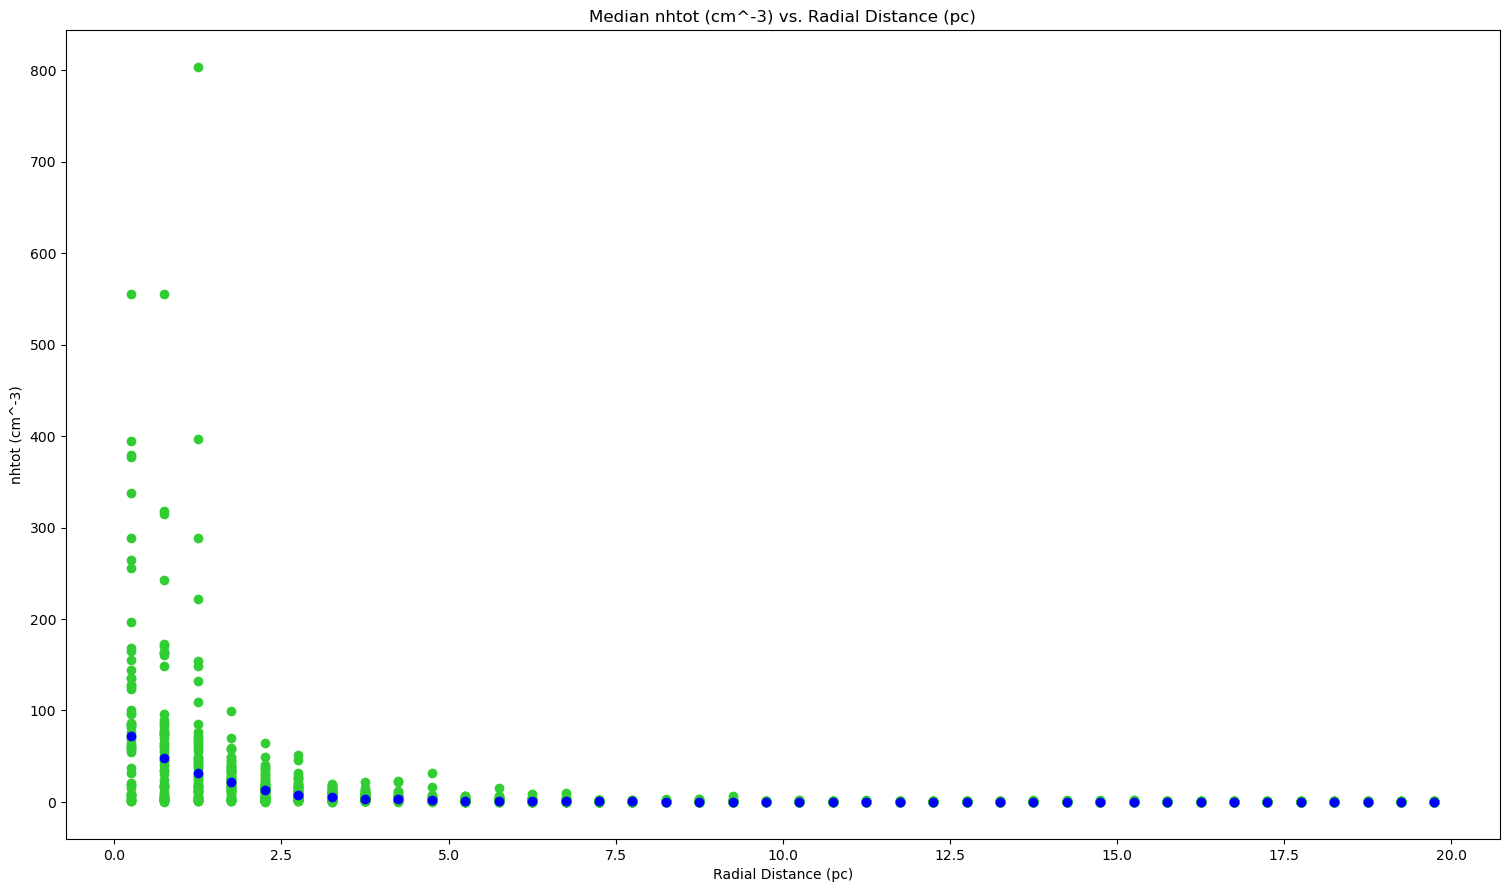


---------------------------
-- Creating Color Plots
---------------------------
Number of points in spline : 58
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57

Htot_35_cloud_factory_test_Htot_animation_0.gif
Htot_35_cloud_factory_test_LOG_Htot_animation_0.gif

---------------------------
-- Creating Gaussians
---------------------------
----------------------------------------
Skeleton 0
----------------------------------------
Max Value : 71.77311992645264
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 30.26237055935772
            Iterations: 13
            Function evaluations: 70
            Gradient evaluations: 13


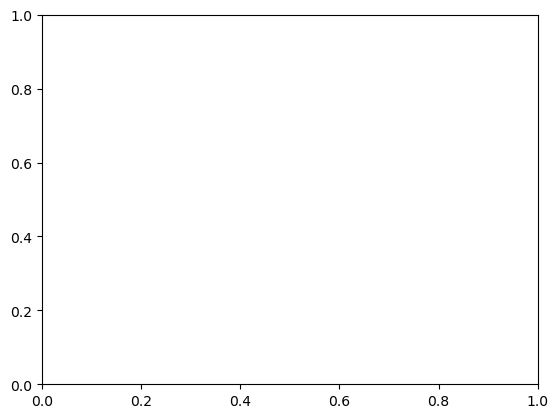

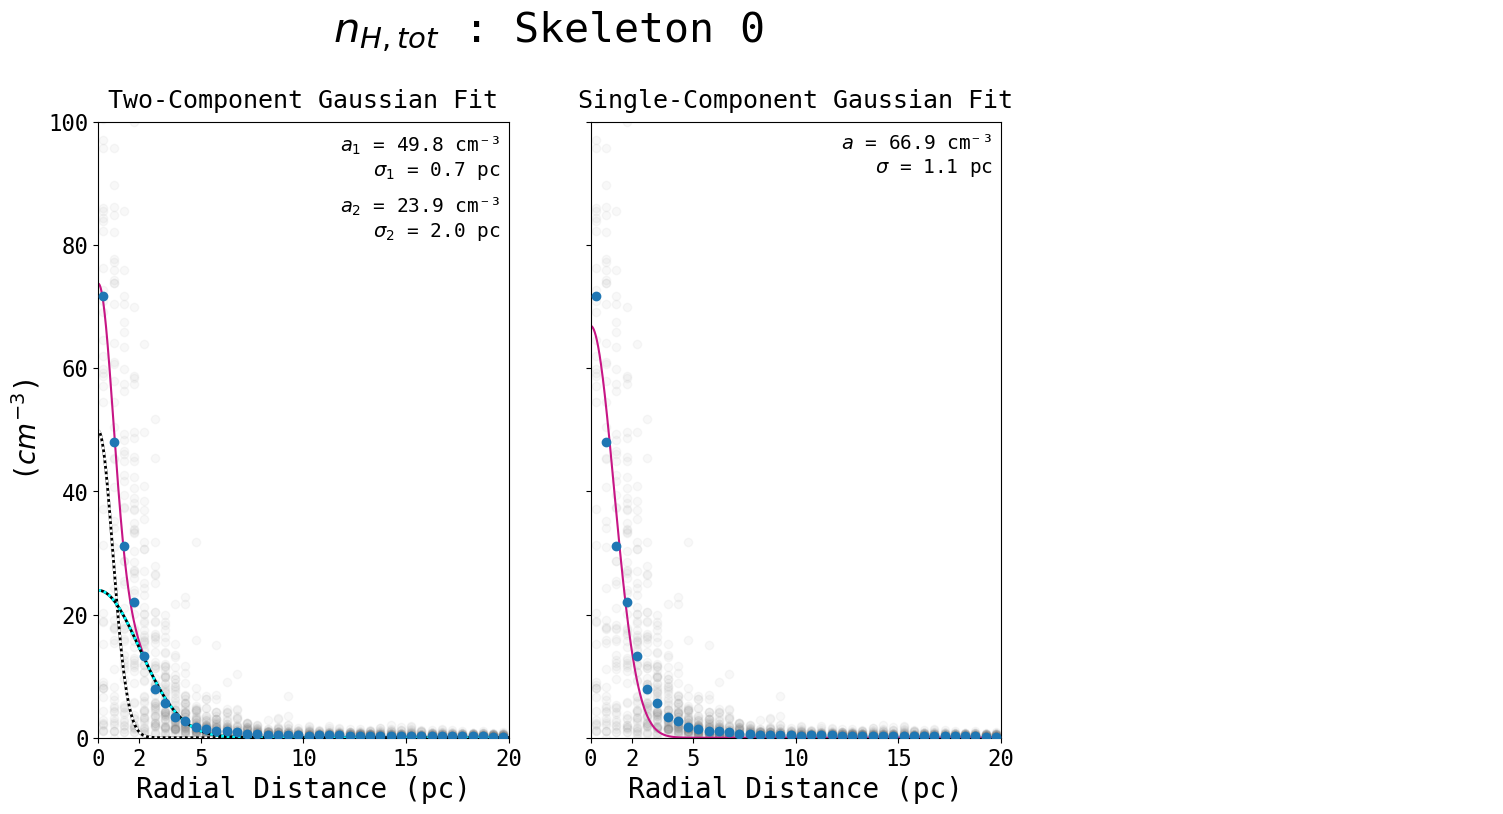

----------------------------------------
Skeleton 0
----------------------------------------
Max Value : 100.36239624023438
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.89094998199446
            Iterations: 22
            Function evaluations: 116
            Gradient evaluations: 22


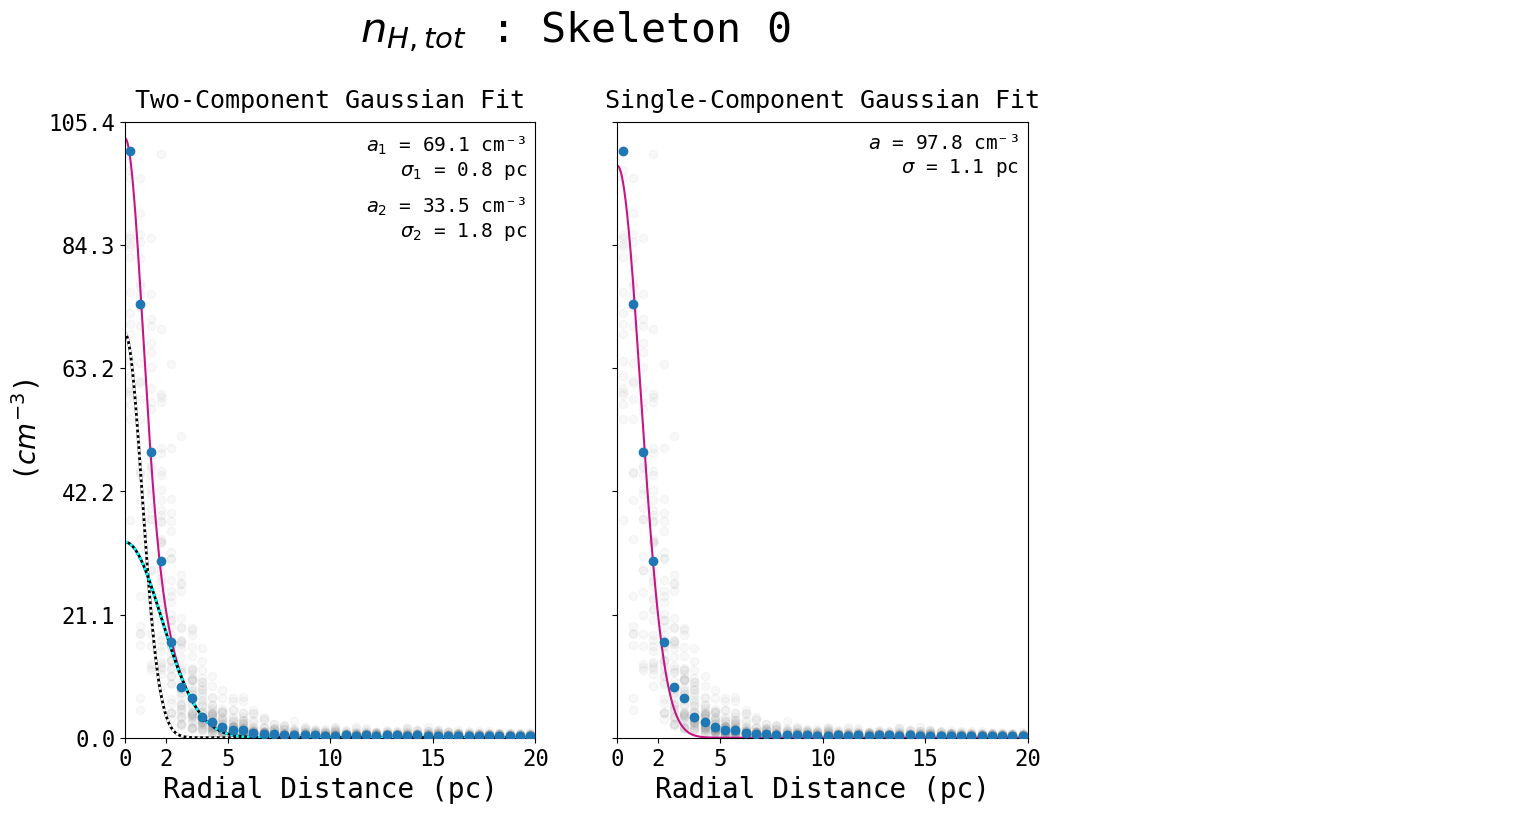

----------------------------------------
Skeleton 0
----------------------------------------
Max Value : 100.36239624023438
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 419.0054583502319
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


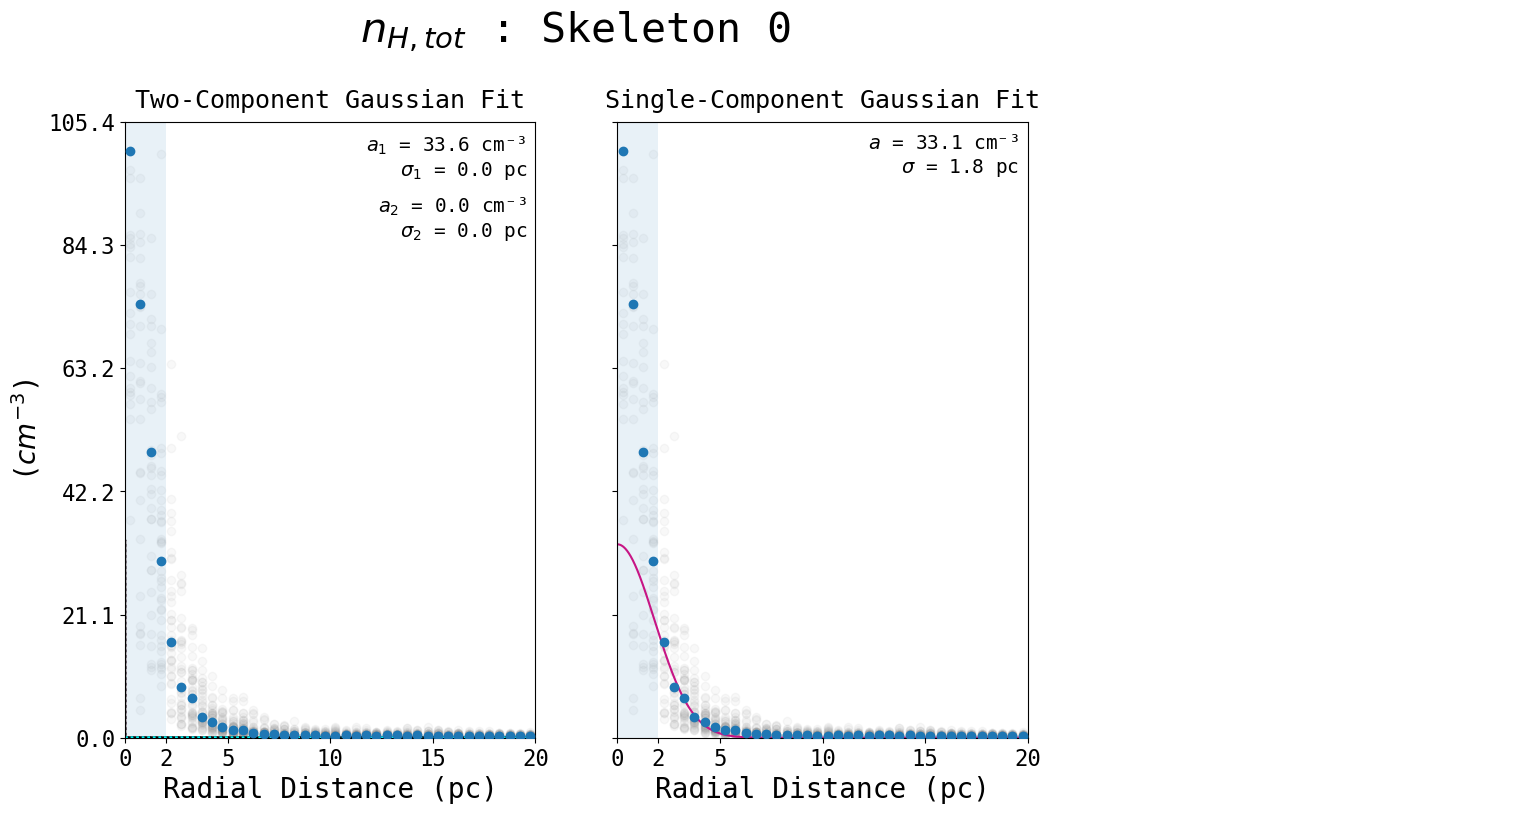

------------------------------------------------------
------------------------------------------------------
Skeleton 1
------------------------------------------------------
------------------------------------------------------

---------------------------
-- Median Scatter Plots
---------------------------
Number of points in spline : 28

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


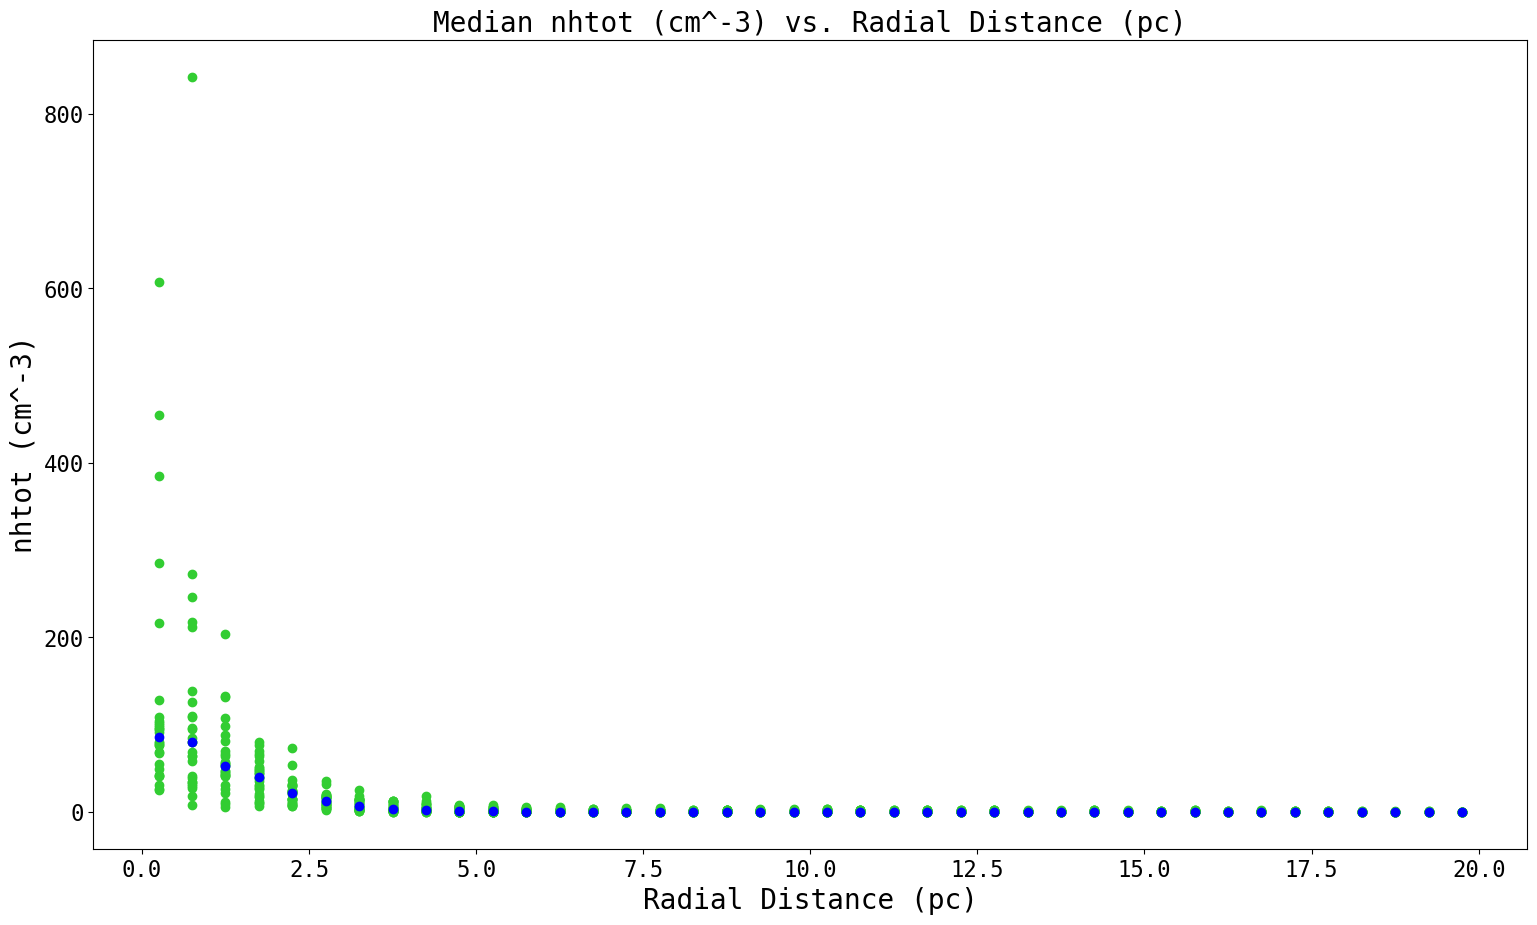


---------------------------
-- Creating Color Plots
---------------------------
Number of points in spline : 28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27

Htot_35_cloud_factory_test_Htot_animation_1.gif
Htot_35_cloud_factory_test_LOG_Htot_animation_1.gif

---------------------------
-- Creating Gaussians
---------------------------
----------------------------------------
Skeleton 1
----------------------------------------
Max Value : 86.0491828918457
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 39.92890969366832
            Iterations: 17
            Function evaluations: 91
            Gradient evaluations: 17


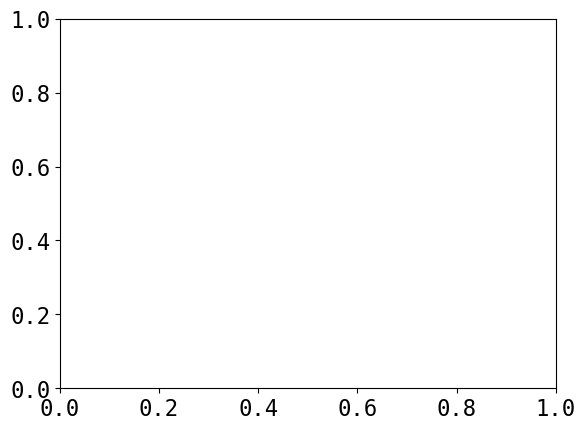

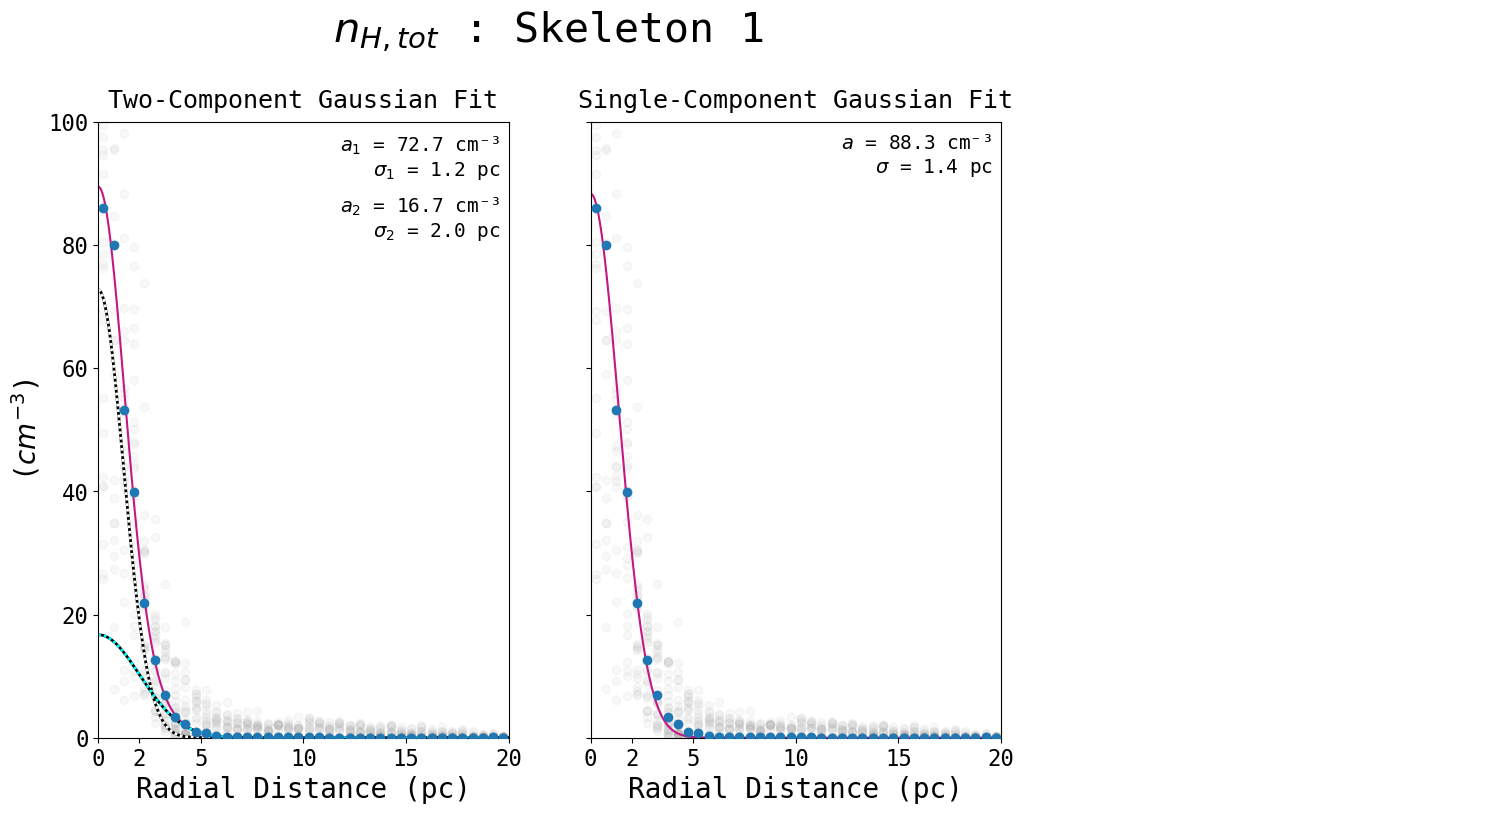

----------------------------------------
Skeleton 1
----------------------------------------
Max Value : 94.58773803710938
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58.122194107127896
            Iterations: 15
            Function evaluations: 81
            Gradient evaluations: 15


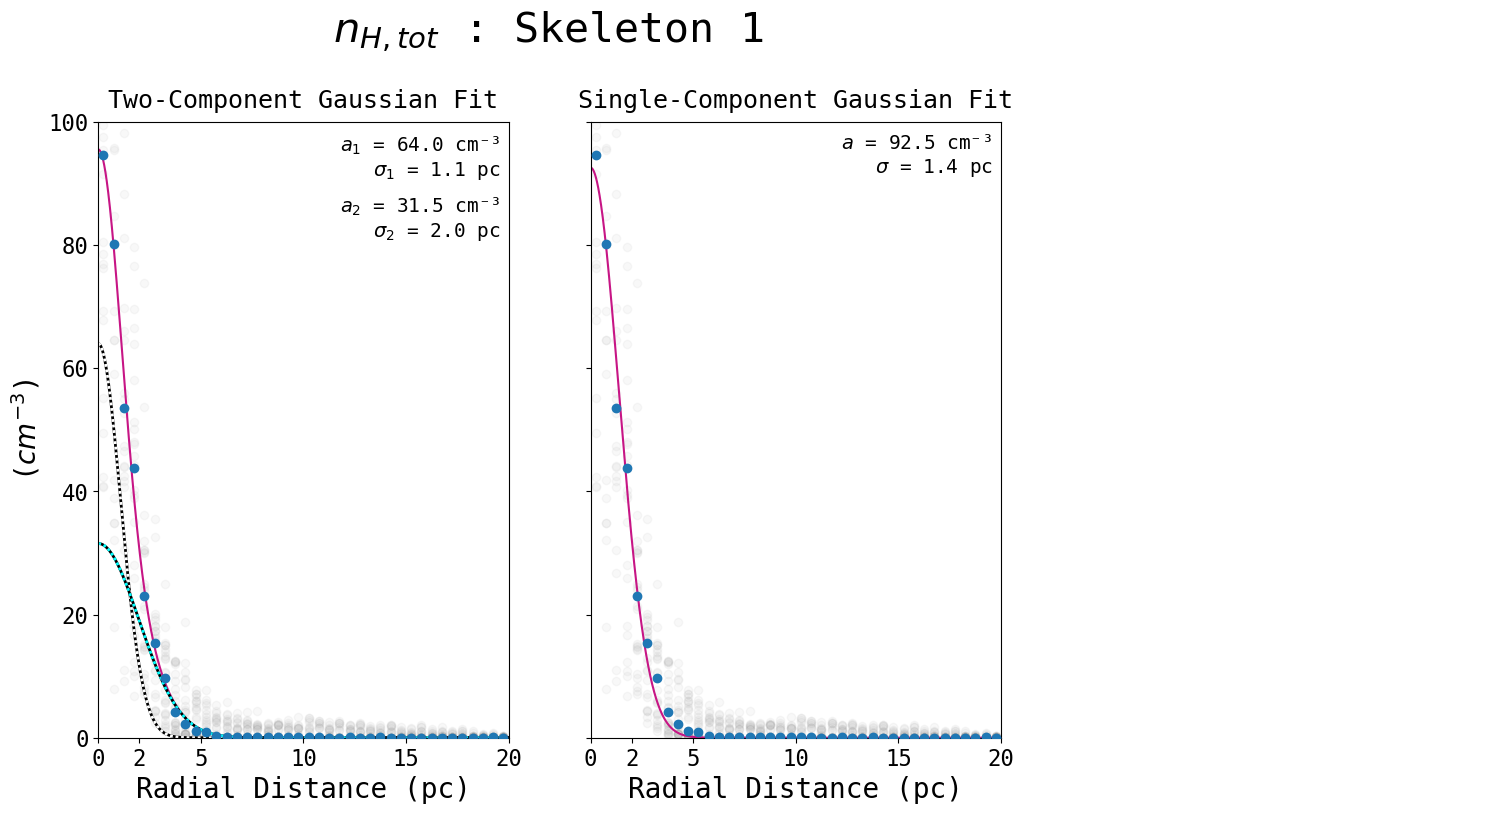

----------------------------------------
Skeleton 1
----------------------------------------
Max Value : 94.58773803710938
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4928095080666304
            Iterations: 31
            Function evaluations: 167
            Gradient evaluations: 31


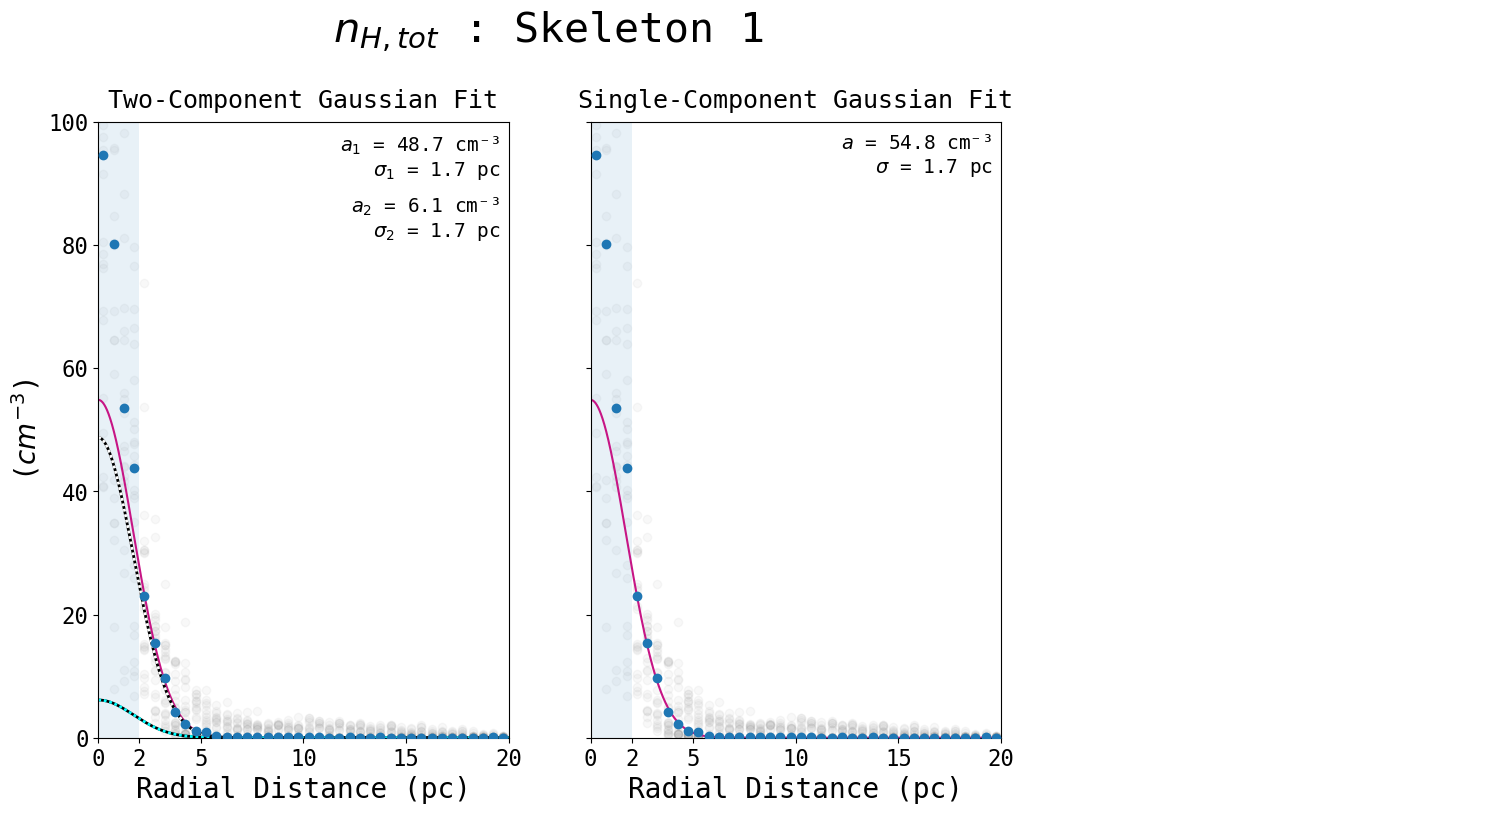

In [18]:
run(file_name_skeleton,file_name_skeleton,designation,cloud_name,grid_type,
   grid_title,grid_units,ball_size,threshold_level,k_num,shift,a1_max_ratio,
   s1_std_ratio,a2_a1_ratio,s2_s1_ratio,start_index,paper_or_no,Zucker_or_no,core_check,threshold_core,
   data,header,data_shape)

# Pipeline Products

1. Data Tables
2. Skeletons and masked clouds 
3. Radial Profiles (Slice-View)
4. Radial Profiles (Gaussian)

# Make Tables 

First, its the gaussian fits without core thresholding and with the inner 2 pc 

Then its the gaussian fits with core thresholding and with the inner 2 pc (if you added core thresholding)

Lastly its the gaussian fits with core thresholding and without the inner 2 pc (if you added Zucker 2021)

In [23]:
t = make_table_row(file_name_skeleton,threshold_level,data,designation,
                          cloud_name,grid_type,
                          shift,False,threshold_core,False)
t.show_in_notebook()

idx,Designation,Thresholded By (cm^-3),Threshold Level (cm^-3),Skeleton Index,Length (pc),Mass (Solar),Htot a1,Htot sigma 1,Htot a2,Htot sigma 2,Htot a,Htot sigma,Htot Max (cm^-3),Htot Median (cm^-3),Htot Mean (cm^-3),Core Shifted?,Core Thresholded?,Thresholded Core (cm^-3),First 2 pc ignored?
0,cloud_factory_test,Htot,35.0,0,65,5857,73.0,1.2,17.0,2.0,88.0,1.4,380.0,46.0,77.0,False,False,---,False
1,cloud_factory_test,Htot,35.0,1,36,2294,73.0,1.2,17.0,2.0,88.0,1.4,9600.0,79.0,420.0,False,False,---,False


In [24]:
if core_check == True:
    t = make_table_row(file_name_skeleton,threshold_level,data,designation,
                          cloud_name,grid_type,
                          shift,True,threshold_core,False)
t.show_in_notebook()

idx,Designation,Thresholded By (cm^-3),Threshold Level (cm^-3),Skeleton Index,Length (pc),Mass (Solar),Htot a1,Htot sigma 1,Htot a2,Htot sigma 2,Htot a,Htot sigma,Htot Max (cm^-3),Htot Median (cm^-3),Htot Mean (cm^-3),Core Shifted?,Core Thresholded?,Thresholded Core (cm^-3),First 2 pc ignored?
0,cloud_factory_test,Htot,35.0,0,65,5857,64.0,1.1,32.0,2.0,93.0,1.4,380.0,46.0,77.0,False,True,> 35,False
1,cloud_factory_test,Htot,35.0,1,36,2294,64.0,1.1,32.0,2.0,93.0,1.4,9600.0,79.0,420.0,False,True,> 35,False


In [25]:
if Zucker_or_no == True:
    t = make_table_row(file_name_skeleton,threshold_level,data,designation,
                          cloud_name,grid_type,
                          shift,True,threshold_core,True)
t.show_in_notebook()

idx,Designation,Thresholded By (cm^-3),Threshold Level (cm^-3),Skeleton Index,Length (pc),Mass (Solar),Htot a1,Htot sigma 1,Htot a2,Htot sigma 2,Htot a,Htot sigma,Htot Max (cm^-3),Htot Median (cm^-3),Htot Mean (cm^-3),Core Shifted?,Core Thresholded?,Thresholded Core (cm^-3),First 2 pc ignored?
0,cloud_factory_test,Htot,35.0,0,65,5857,49.0,1.7,6.1,1.7,55.0,1.7,380.0,46.0,77.0,False,True,> 35,True
1,cloud_factory_test,Htot,35.0,1,36,2294,49.0,1.7,6.1,1.7,55.0,1.7,9600.0,79.0,420.0,False,True,> 35,True


# View the Skeletonization

This will show the grid, flattened on one axis with the skeleton. All three axis are shown (remember these skeletons and clouds are 3D objects, these are just 2D projections)

Make sure the indices when loading in the files match the loading in steps
['nhtot_x1470y1400z1400.fits', 'nhtot_x1470y1400z1400_35_thresholded_data.fits', 'nhtot_x1470y1400z1400_35_skeleton.fits']
Axis =  0


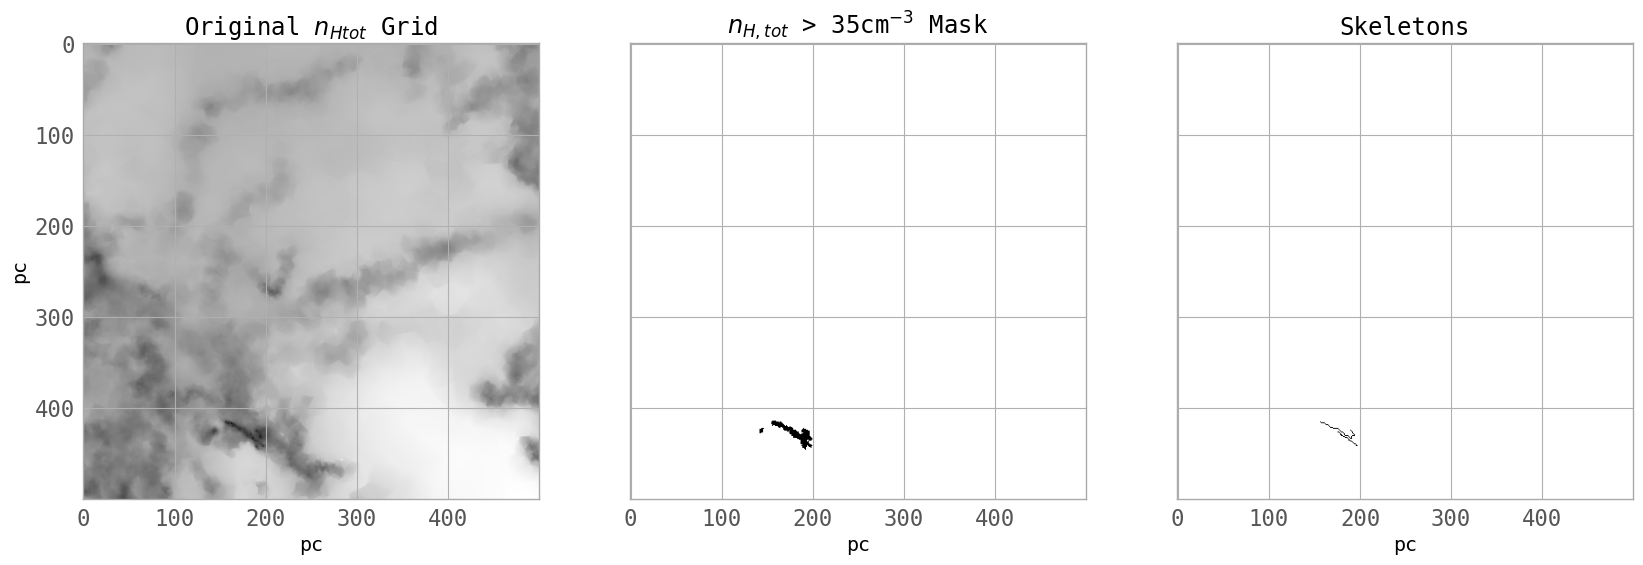

Axis =  1


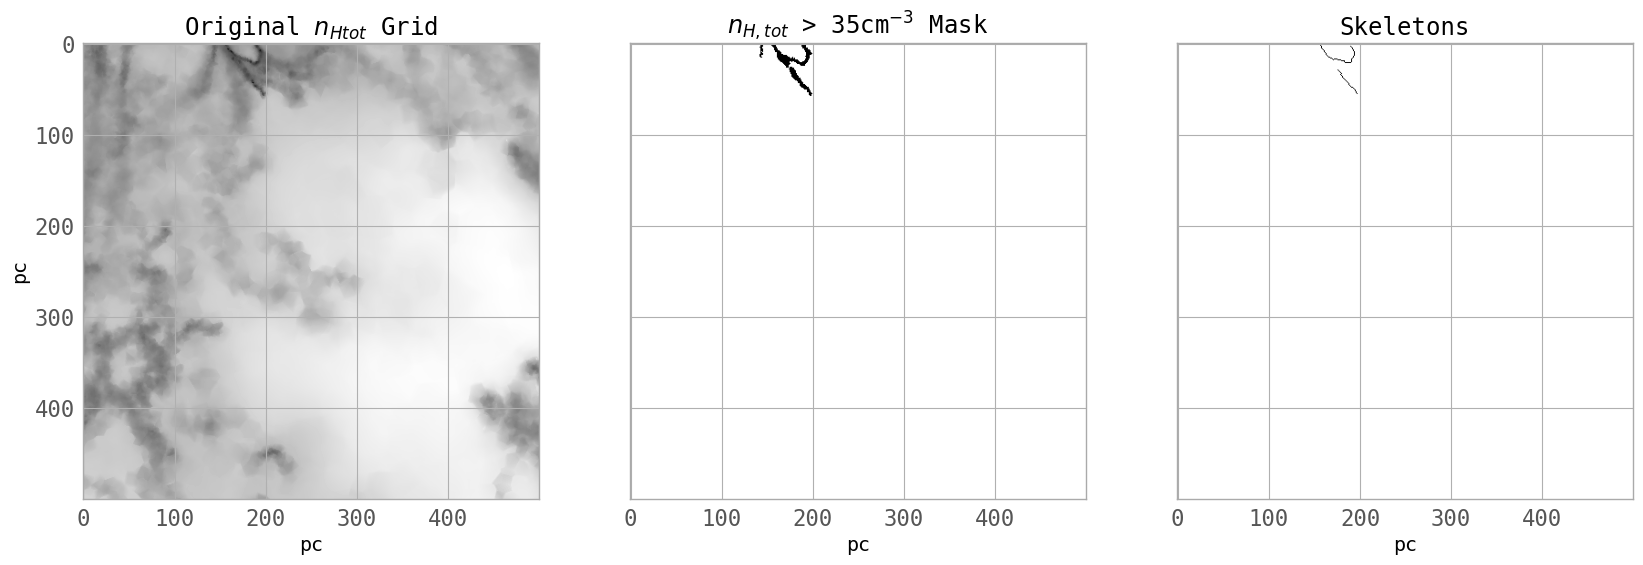

Axis =  2


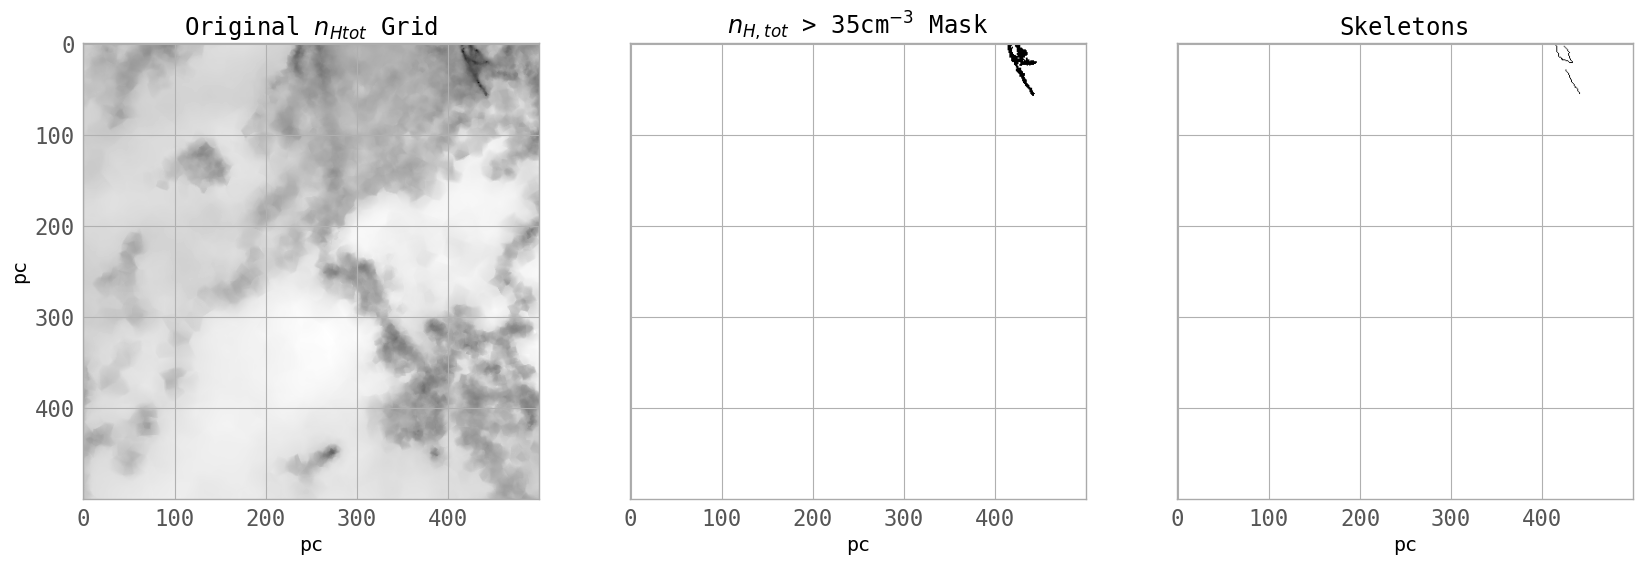

In [29]:
import matplotlib.pyplot as plt
import glob as glob
import numpy as np

# Set up plot stylization 
# Note that this plot style will mess up future gaussian graphs if the same notebook is run.
# Make sure to restart the kernel before rerunning the pipeline
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from matplotlib import rcParams
from matplotlib.patches import Rectangle

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# Load in all the nhtot fits files
data_table = glob.glob('nhtot*.fits')
print('Make sure the indices when loading in the files match the loading in steps')
print(data_table)

# Axis to sum on
axis_array = [0,1,2]

for axis in axis_array:

    print('Axis = ', axis)

    # Load in the grid 
    image_file = get_pkg_data_filename(data_table[0])
    image_data = fits.getdata(data_table[0])
    image_data = np.sum(image_data,axis=axis)
    image_data_sim = image_data

    # Load in the mask 
    image_file = get_pkg_data_filename(data_table[1])
    image_data = fits.getdata(image_file, ext=0)
    image_data = np.sum(image_data,axis=axis)
    image_data[image_data !=0] = 1
    image_data_mask = image_data

    # Load in the skeleton
    image_file = get_pkg_data_filename(data_table[2])
    image_data = fits.getdata(image_file, ext=0)
    image_data = np.sum(image_data,axis=axis)
    image_data[image_data !=0] = 1
    image_data_skeleton = image_data

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize = (20,15))

    ax1.imshow(np.log10(image_data_sim),  cmap='gray_r')
    ax1.set_xlabel('pc')
    ax1.set_ylabel('pc')
    string = 'Original ' + grid_title + ' Grid'
    ax1.set_title('Original $n_{Htot}$ Grid')

    ax2.imshow(image_data_mask,  cmap='gray_r')
    ax2.set_xlabel('pc')
    string = grid_title + ' > ' + str(threshold_level) +  'cm$^{-3}$ Mask'
    ax2.set_title(string)

    ax3.imshow(image_data_skeleton,  cmap='gray_r')
    ax3.set_xlabel('pc')
    ax3.set_title('Skeletons')

    plt.show()

# Radial Profile Gifs 

This output product can give you a view of the actual structure of a cloud's radial profile. 

There are two outputs for each tracer 

Each frame in the gif indicates the frame number, and the coordinate in the simulation that represents the 0,0 of the graph. 

A UV linear transformation is used to project the 3D slice onto a 2D plane. 

1. A non-log version. Do note that the colorbar does not stay constant in these versions of the gifs 
2. A log version. The colorbar stays constant no matter which slice you are looking at. 

Number of frames: 28
Showing 5 frames :  [ 0.    6.75 13.5  20.25 27.  ]


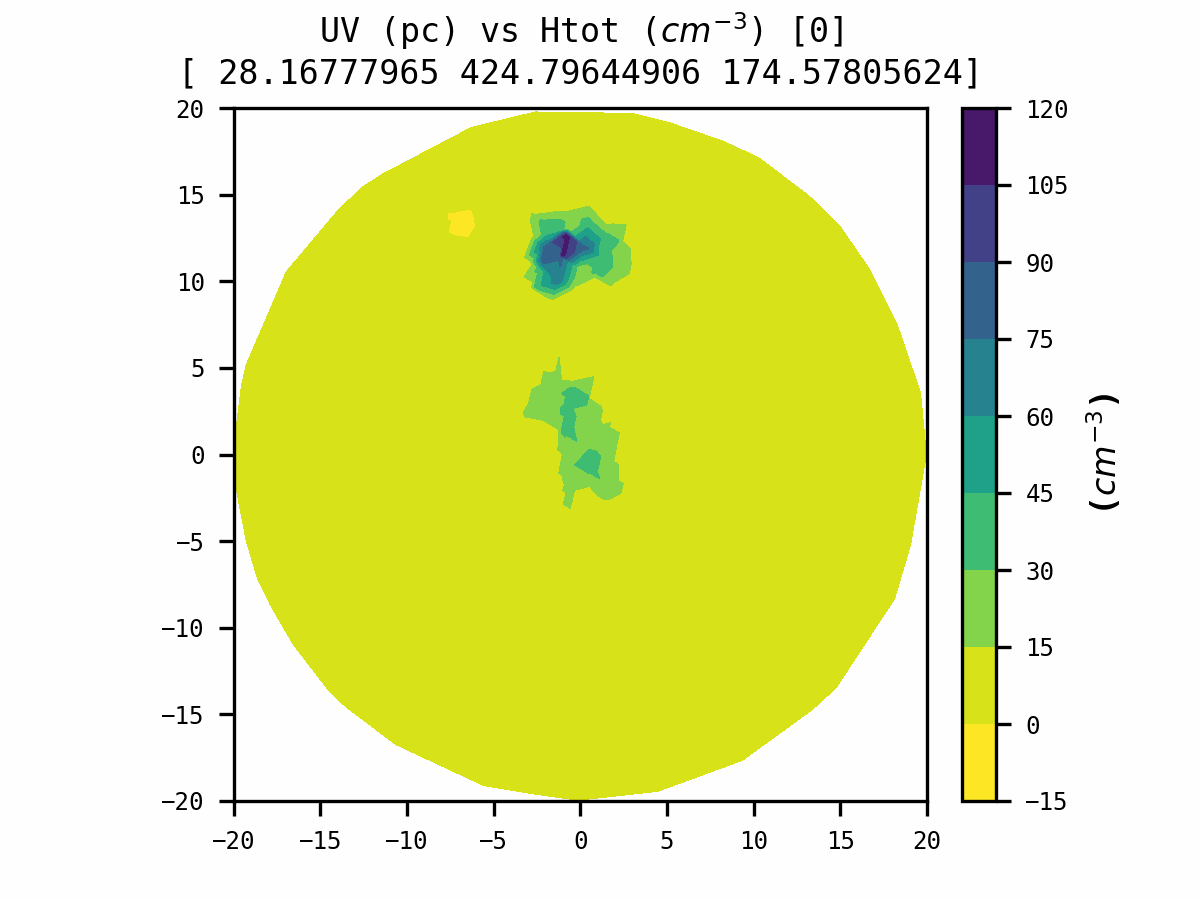

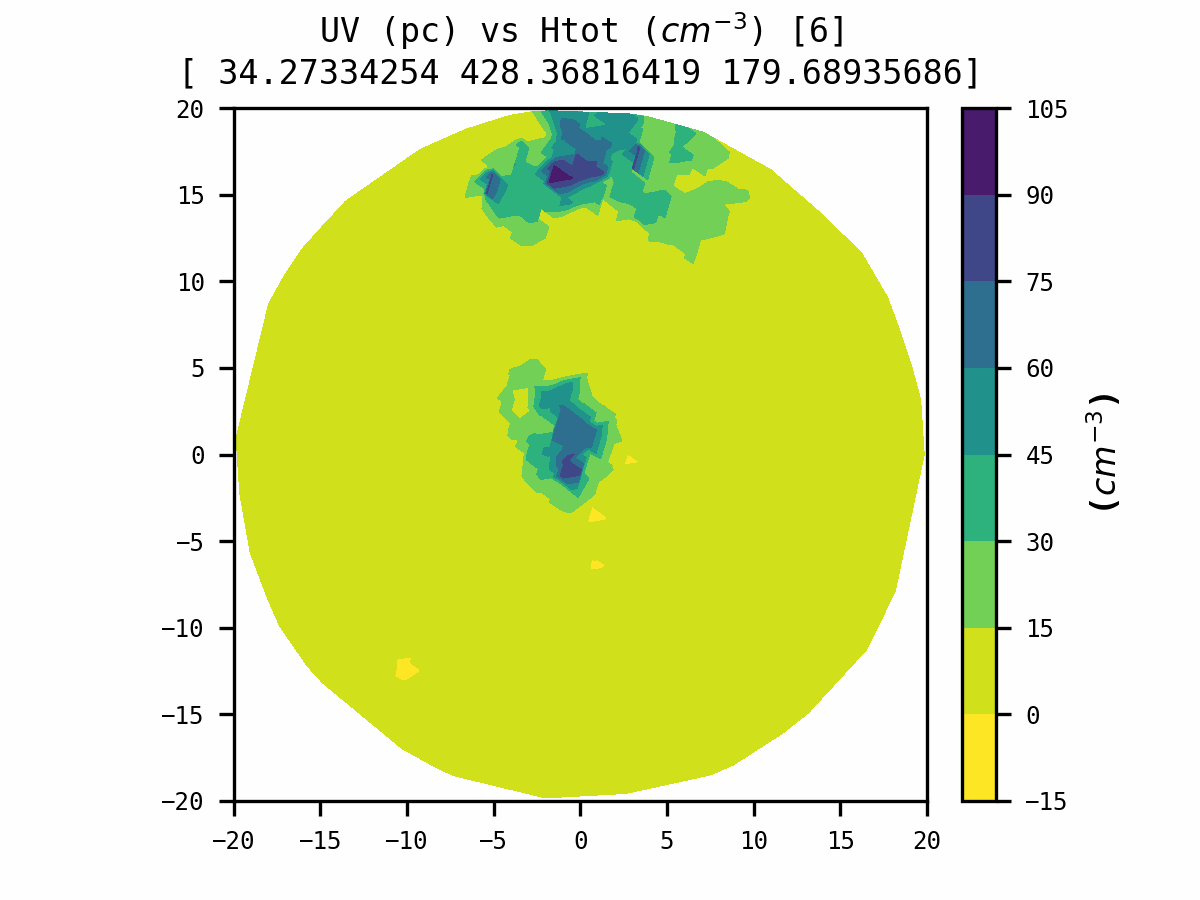

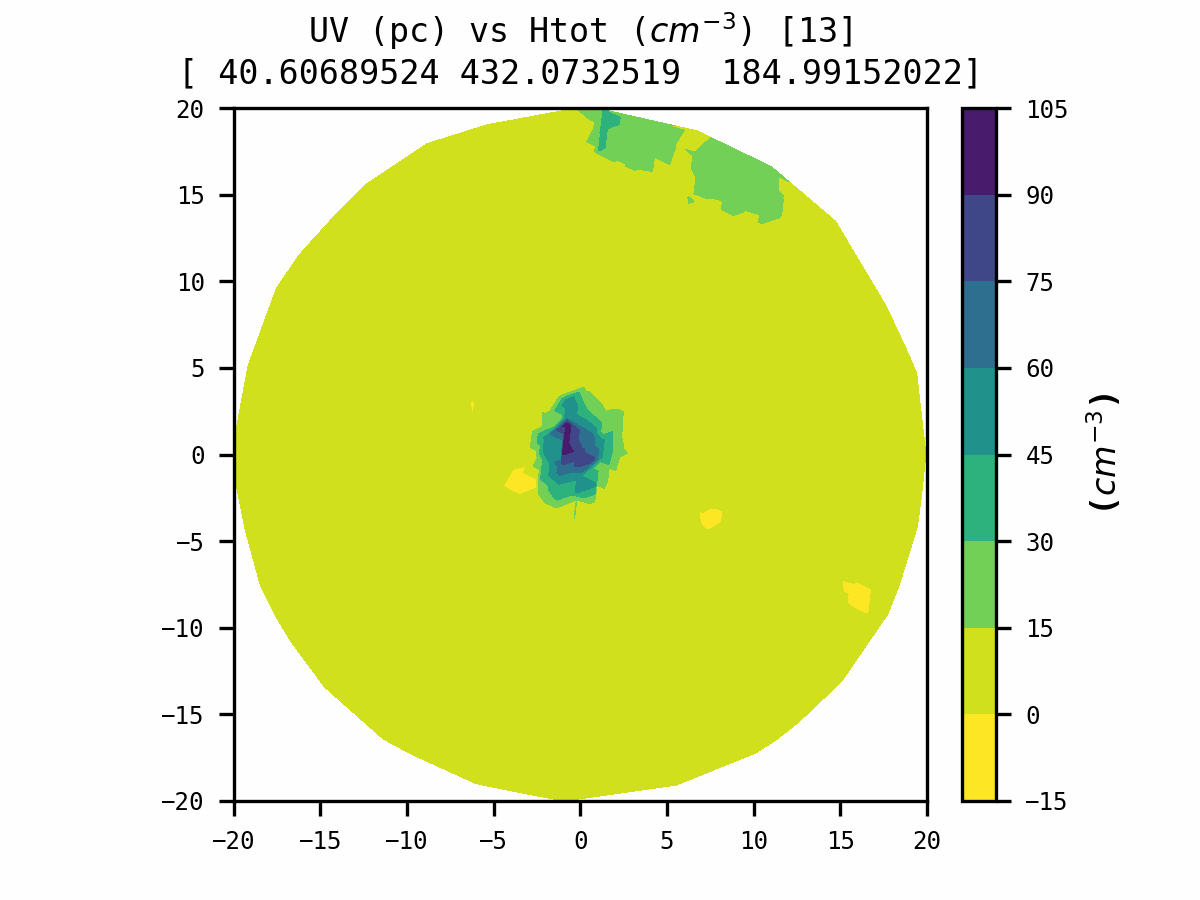

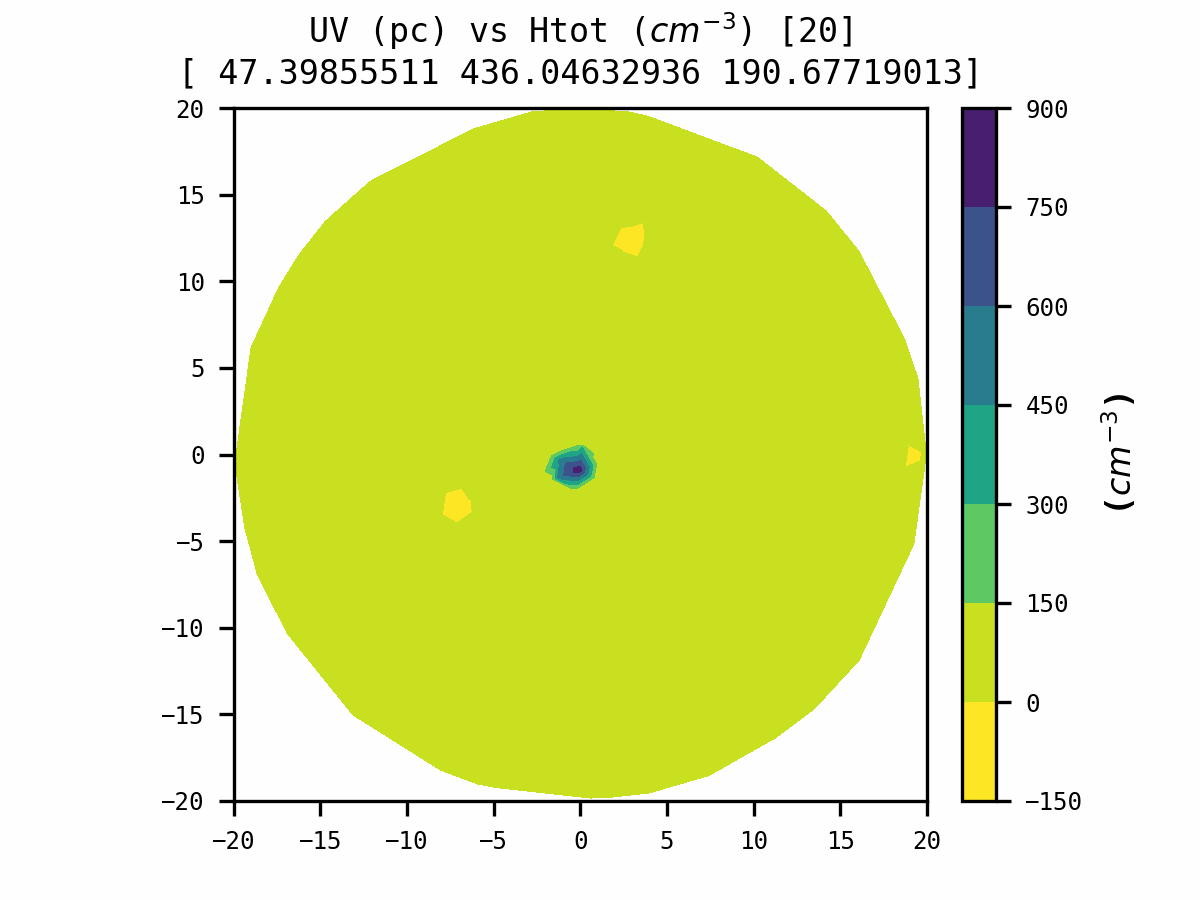

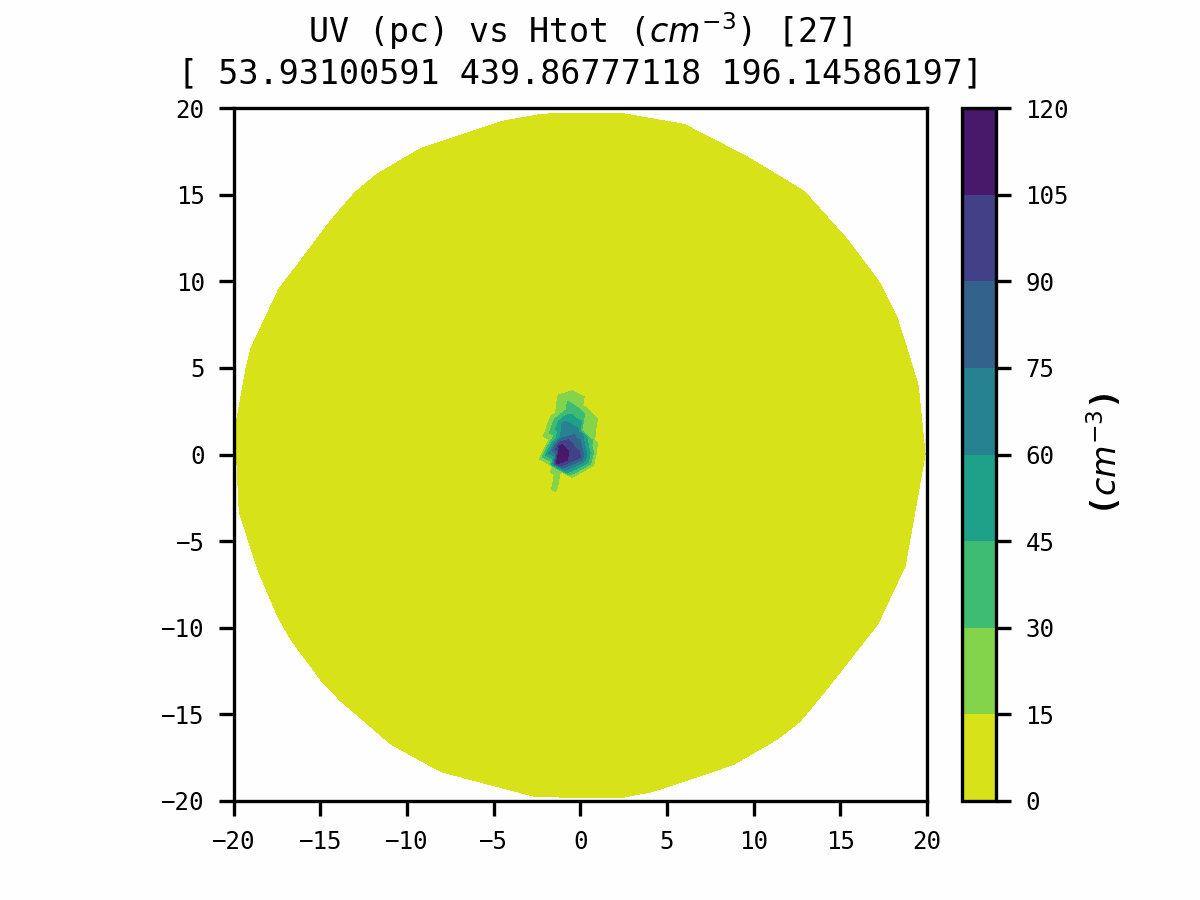

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

cloud_number = 1
gif_file_name = './Htot_35_cloud_factory_test_Htot_animation_' + str(cloud_number) + '.gif'
im = Image.open(gif_file_name)

print("Number of frames: " +str(im.n_frames))

frames = np.linspace(0,im.n_frames-1,5)

print('Showing 5 frames : ', frames)

for frame in frames:
    im = Image.open(gif_file_name)
    frame = int(frame)
    im.seek(frame)
    display(im)

Number of frames: 28
Showing 5 frames :  [ 0.    6.75 13.5  20.25 27.  ]


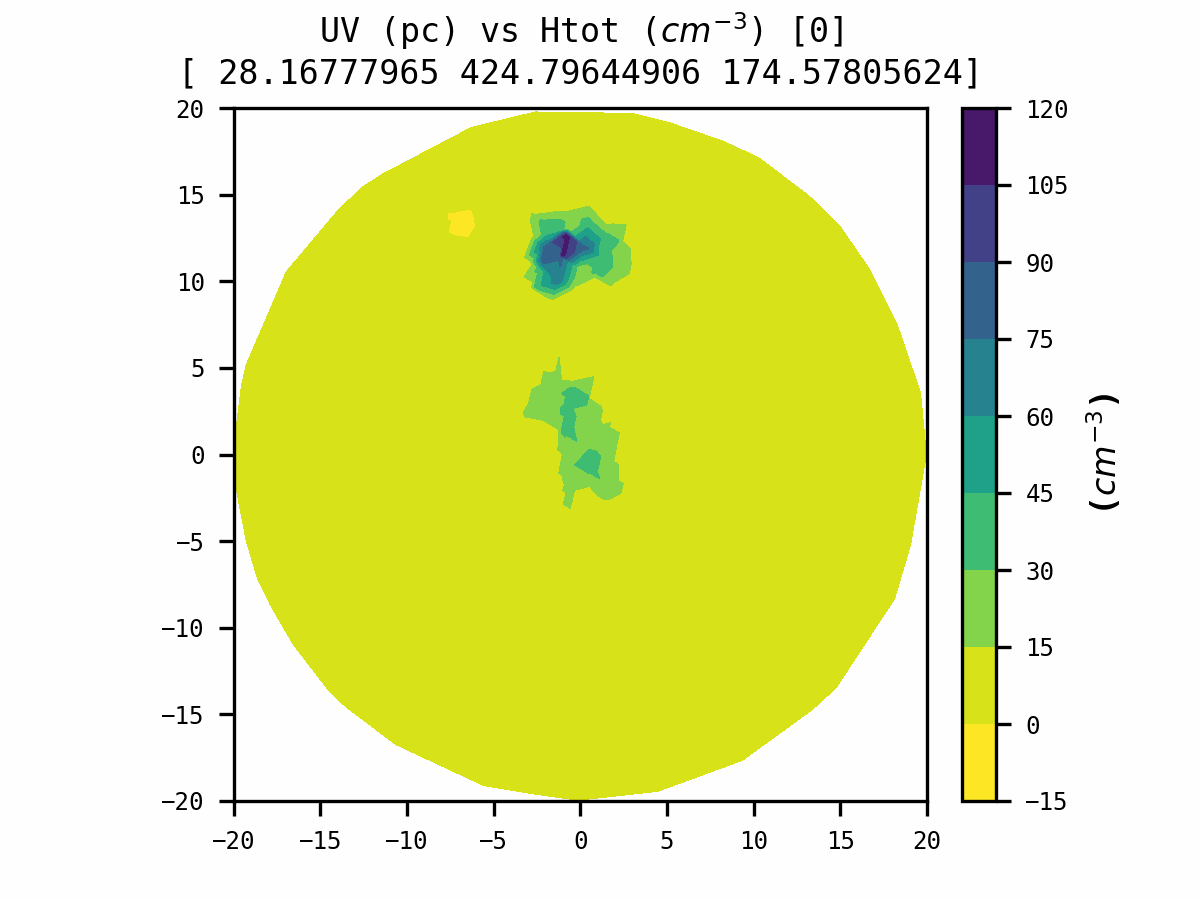

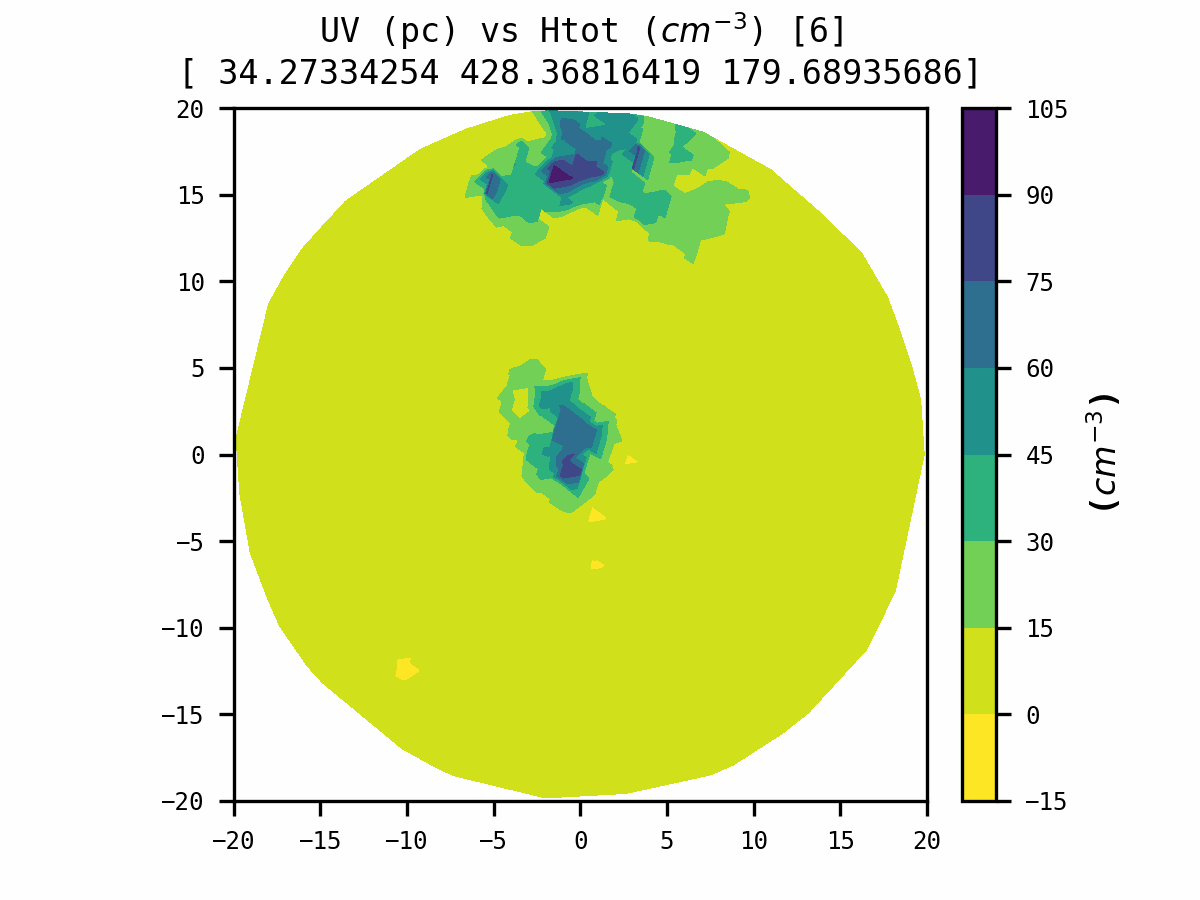

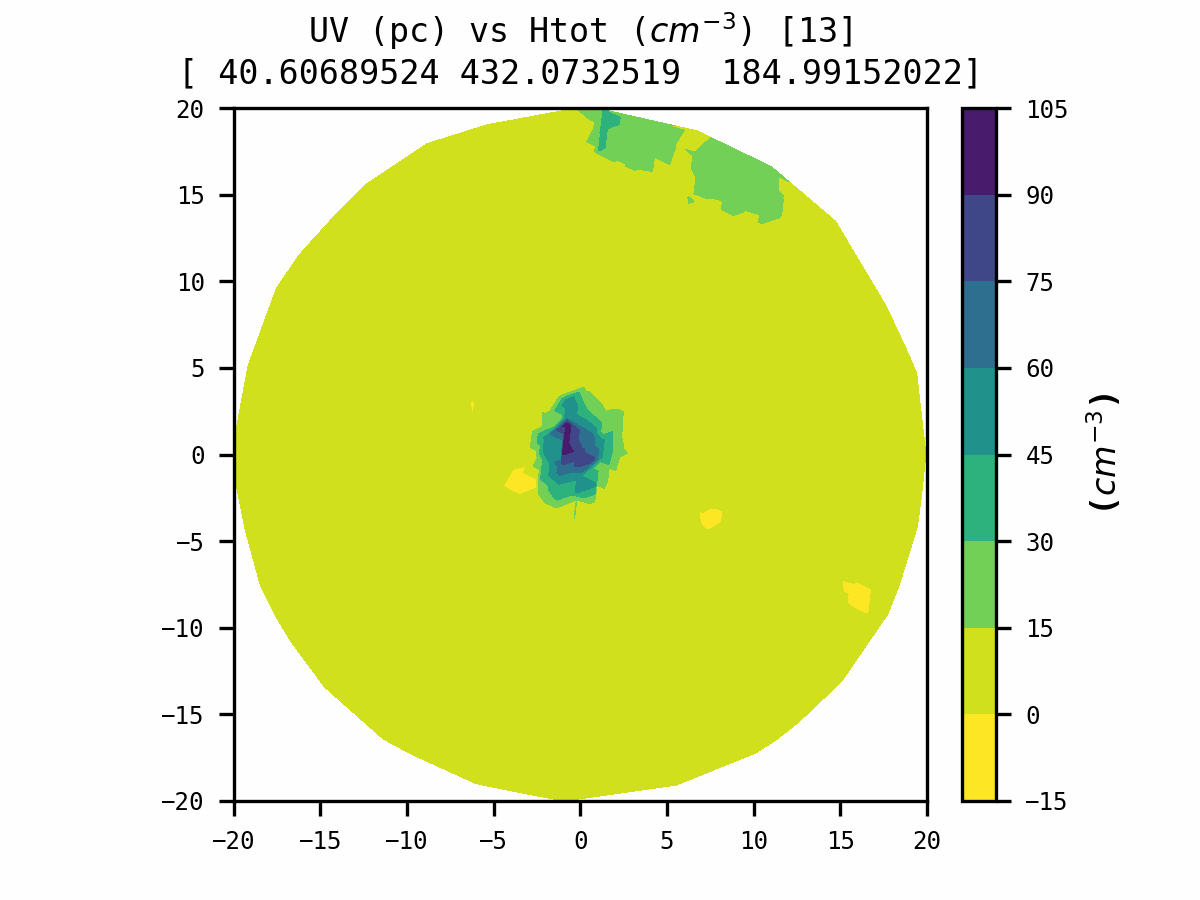

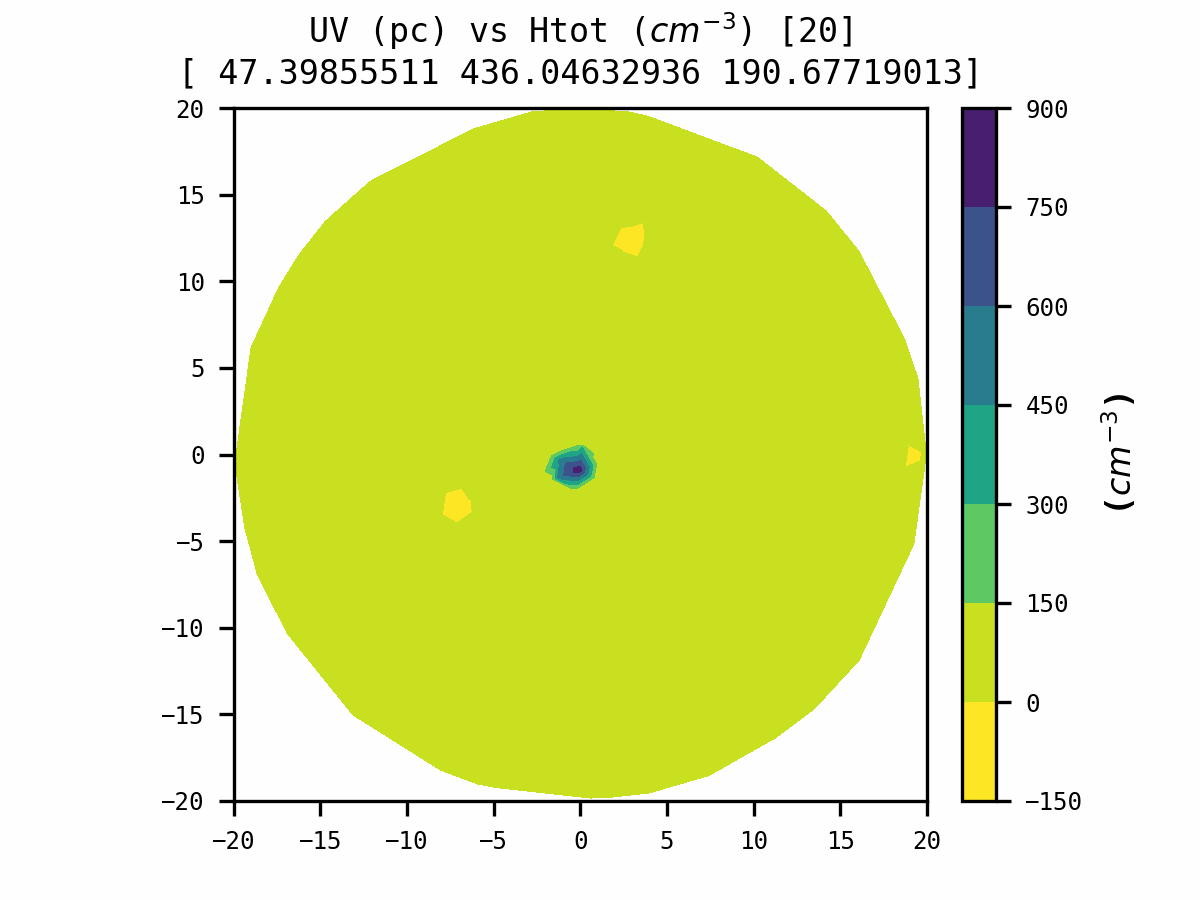

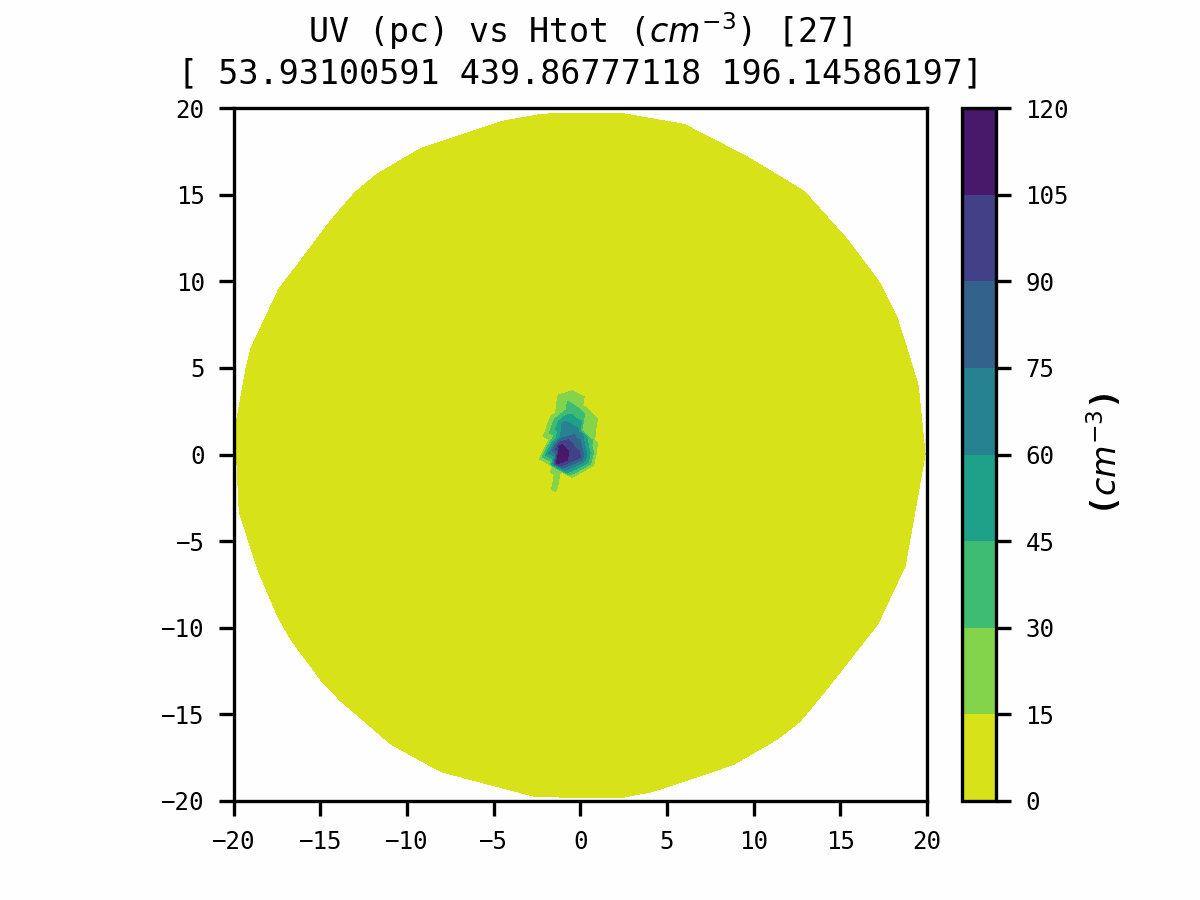

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

cloud_number = 1
gif_file_name = './Htot_35_cloud_factory_test_Htot_animation_' + str(cloud_number) + '.gif'
im = Image.open(gif_file_name)

print("Number of frames: " +str(im.n_frames))

frames = np.linspace(0,im.n_frames-1,5)

print('Showing 5 frames : ', frames)

for frame in frames:
    im = Image.open(gif_file_name)
    frame = int(frame)
    im.seek(frame)
    display(im)

# Radial Profile Fits 

There are three pdfs available with the fit gaussians to the radial profiles of each cloud.

1. Regular gaussian, with no skeleton points excluded from analysis 
2. A gaussian where radial profiles with skeleton points with densities less than threshold_core (= 190) are exluded from the fit. 
3. A gaussian where radial profiles skeleton points with densities less than threshold_core (= 190) are exluded from the fits, and the inner two parsecs are not included in the fit (consistent with Zucker2021)

----------------------------------------
Skeleton 1
----------------------------------------
Max Value : 86.0491828918457
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 39.92890969366832
            Iterations: 17
            Function evaluations: 91
            Gradient evaluations: 17


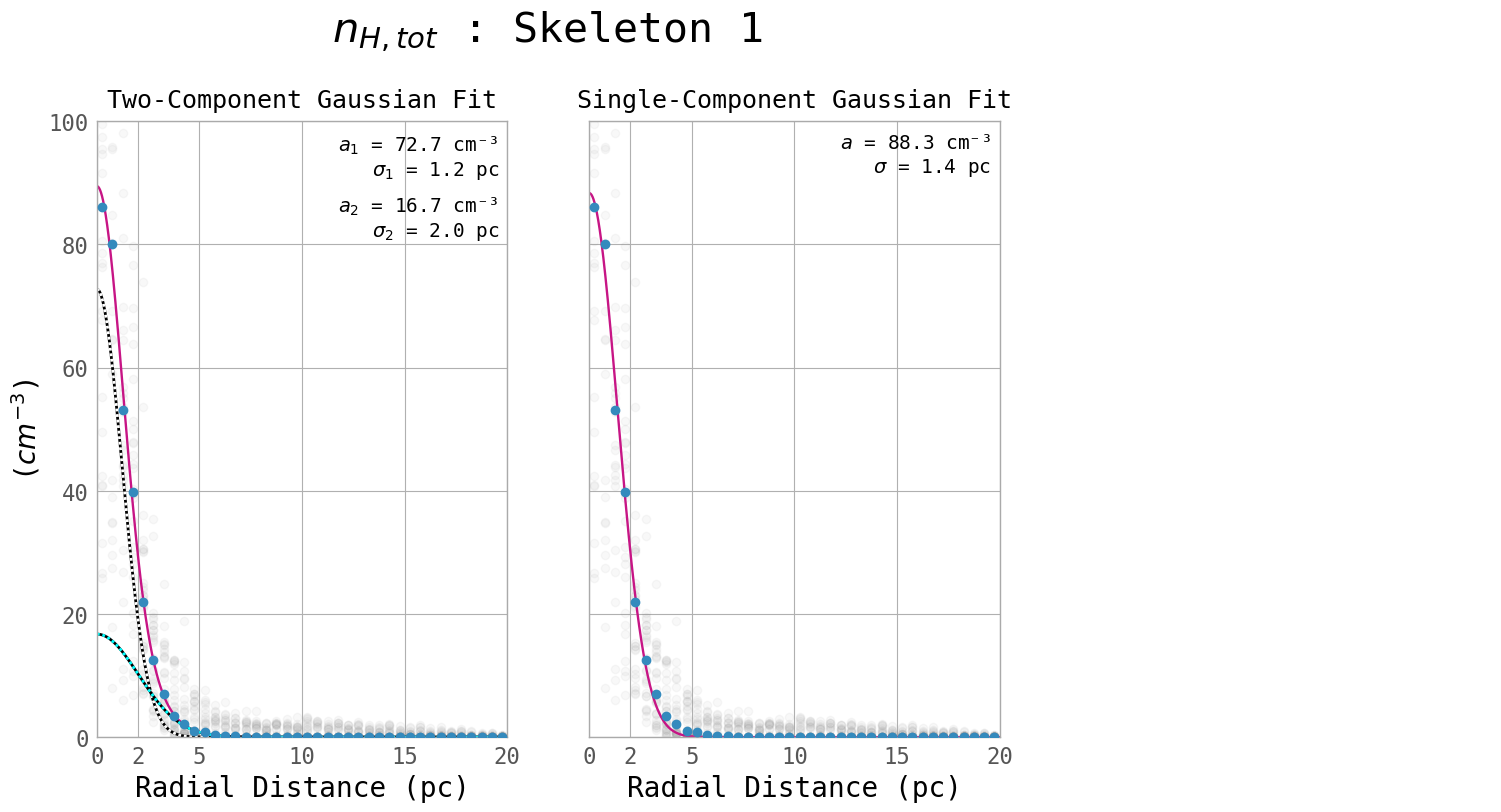

In [35]:
# Cloud Number (which cloud to load)
cloud_number = 1

# A string needed for the function
sort_plus_threshold_name = grid_type + "_" + str(threshold_level) + "_" + cloud_name

gaussians_plot_paper(cloud_number,
                        a1_max_ratio,s1_std_ratio,
                        a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name,cloud_name,
                        False,threshold_core,
                        grid_type,grid_title,grid_units)

----------------------------------------
Skeleton 1
----------------------------------------
Max Value : 94.58773803710938
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58.122194107127896
            Iterations: 15
            Function evaluations: 81
            Gradient evaluations: 15


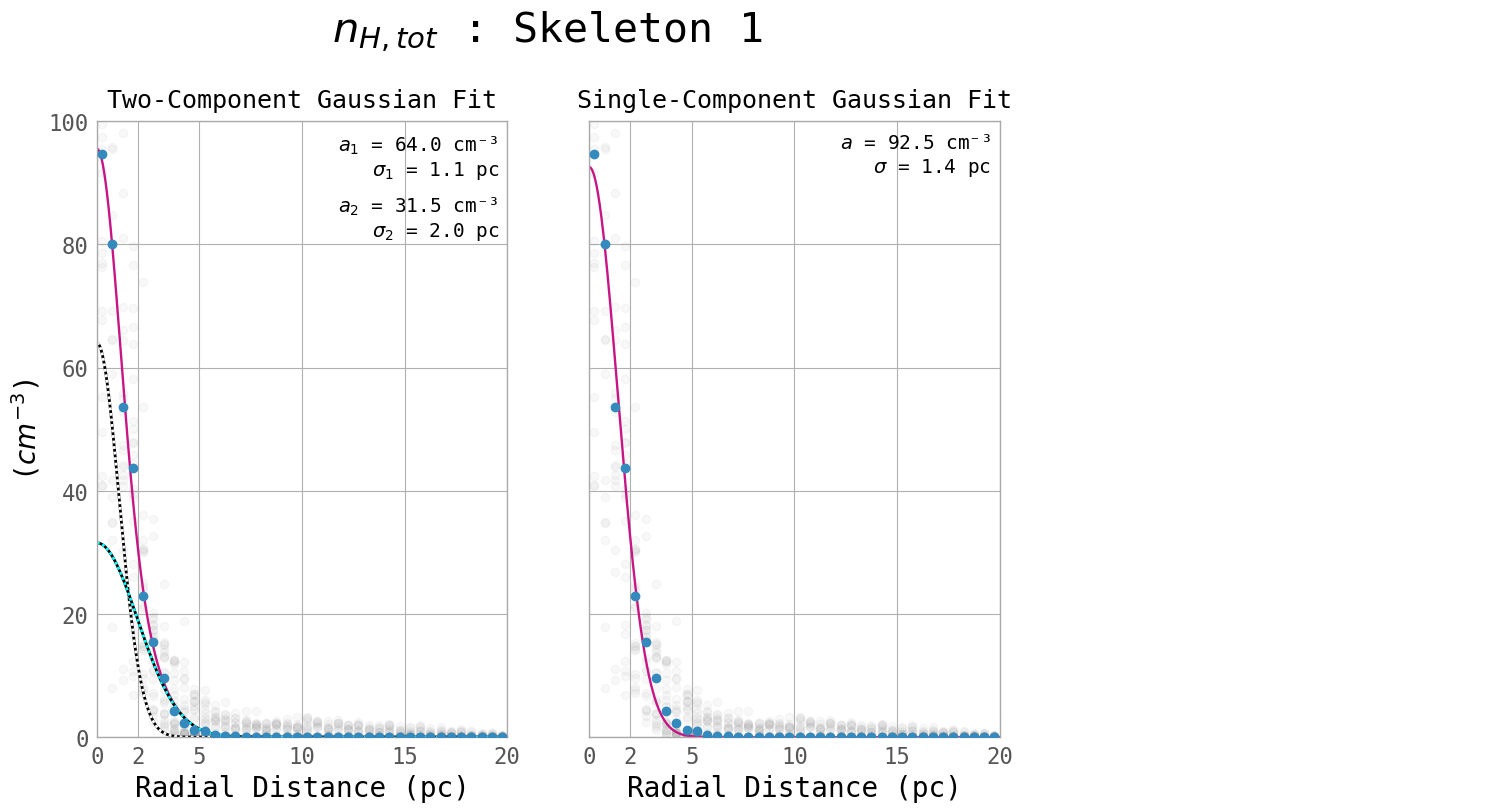

In [36]:
 gaussians_plot_paper(cloud_number,
                        a1_max_ratio,s1_std_ratio,
                        a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name,cloud_name,
                        True,threshold_core,
                        grid_type,grid_title,grid_units)

----------------------------------------
Skeleton 1
----------------------------------------
Max Value : 94.58773803710938
Std : 5.771698190307598
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4928095080666304
            Iterations: 31
            Function evaluations: 167
            Gradient evaluations: 31


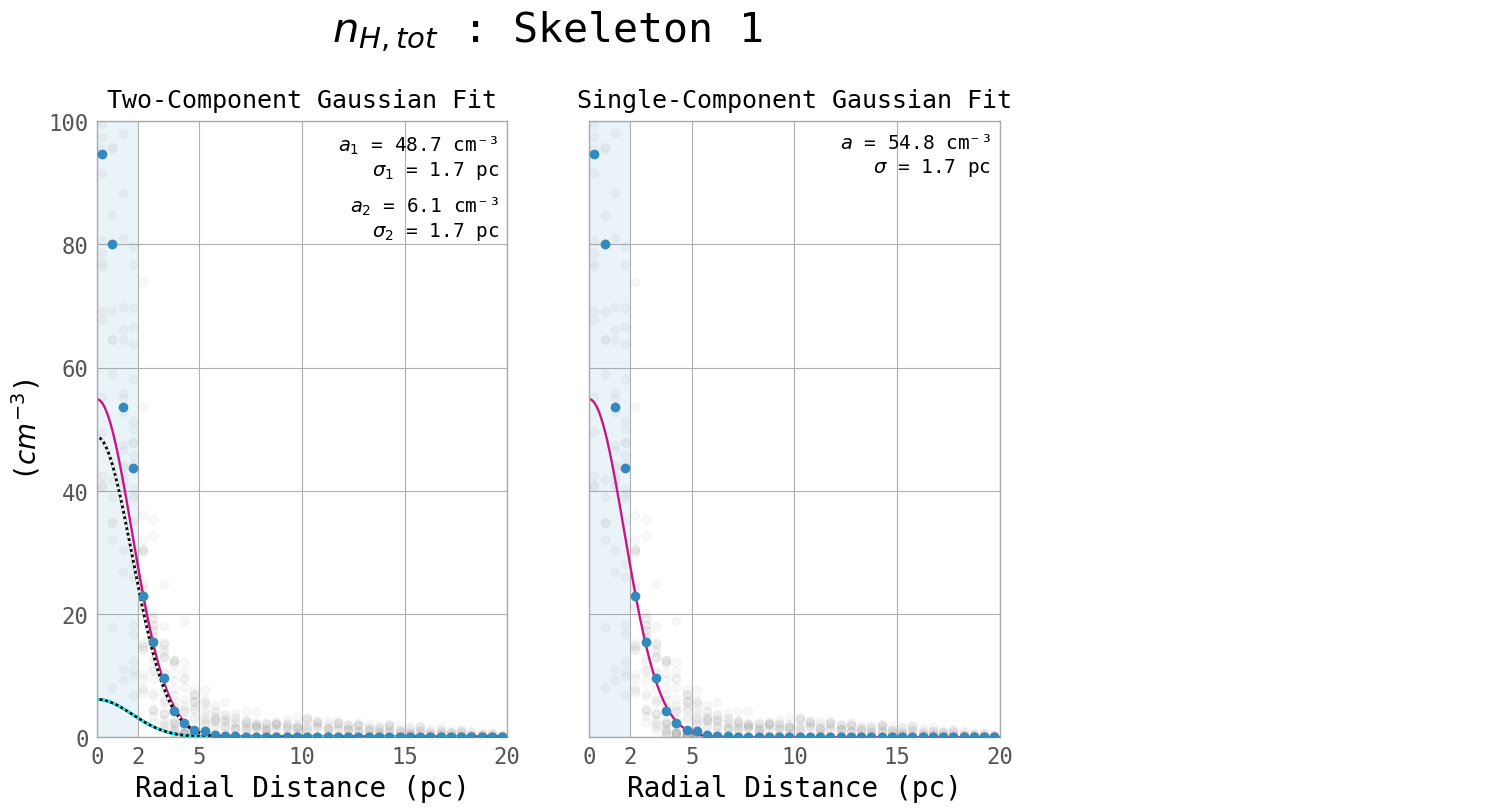

In [37]:
gaussians_plot_paper_Zucker2021(cloud_number,
                            a1_max_ratio,s1_std_ratio,
                            a2_a1_ratio,s2_s1_ratio,start_index,sort_plus_threshold_name,cloud_name,
                            True,threshold_core,
                            grid_type,grid_title,grid_units,
                            4)